In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 100)
sns.set()

In [2]:
import datetime

In [3]:
#df_raw = pd.read_parquet("data/sku_sales.parquet").sample(100000)
df = pd.read_parquet("../data/data_weekly.parquet")

In [4]:
val_weeks = [pd.to_datetime("2025-09-16") - pd.Timedelta(days=7*8) * i for i in range(1, 8)]
val_weeks

[Timestamp('2025-07-22 00:00:00'),
 Timestamp('2025-05-27 00:00:00'),
 Timestamp('2025-04-01 00:00:00'),
 Timestamp('2025-02-04 00:00:00'),
 Timestamp('2024-12-10 00:00:00'),
 Timestamp('2024-10-15 00:00:00'),
 Timestamp('2024-08-20 00:00:00')]

### Val weeks

In [4]:
df["date"].min(), df["date"].max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2025-09-16 00:00:00'))

In [6]:
(df["date"].max() - df["date"].min()).days

2085

In [7]:
2085 * 0.2

417.0

In [10]:
datetime.date(2025, 9, 16) - datetime.timedelta(days=417)

datetime.date(2024, 7, 26)

In [11]:
417/3

139.0

In [12]:
datetime.date(2024, 7, 26) + datetime.timedelta(days=139), datetime.date(2024, 7, 26) + datetime.timedelta(days=139 * 2)

(datetime.date(2024, 12, 12), datetime.date(2025, 4, 30))

In [13]:
val_weeks = [pd.to_datetime("2024-07-26"), pd.to_datetime("2024-12-12"), pd.to_datetime("2025-04-30")]

In [18]:
417 / 8

52.125

In [6]:
365 / (7*8)

6.517857142857143

In [41]:
val_weeks = [pd.to_datetime("2025-09-16") - pd.Timedelta(days=7*8) * i for i in range(1, 8)]
val_weeks

[Timestamp('2025-07-22 00:00:00'),
 Timestamp('2025-05-27 00:00:00'),
 Timestamp('2025-04-01 00:00:00'),
 Timestamp('2025-02-04 00:00:00'),
 Timestamp('2024-12-10 00:00:00'),
 Timestamp('2024-10-15 00:00:00'),
 Timestamp('2024-08-20 00:00:00')]

### Train manually on one val_week

In [14]:
train = df[df["date"] < val_weeks[0]]

In [85]:
test = df[(df["date"] >= val_weeks[0]) & (df["date"] < pd.to_datetime(val_weeks[0]) + pd.Timedelta(days=8*7))]

In [15]:
target = "sales"
features = [c for c in train if c not in [target, "date", "sku"]]

In [121]:
from typing import List, Tuple

def calc_quality(df: pd.DataFrame, predict_colname: str, hist_bias_borders: Tuple[float, float] = (-0.2, 0.2)) -> pd.DataFrame:
    df["target"] = df["sales"].fillna(0).apply(lambda x: max(x, 0))
    
    df["err"] = df[predict_colname] - df["target"]
    df["abs_err"] = df["err"].abs()
    df["max_val"] = df[["err", "target"]].max(axis=1)
    df["rel_err"] = df["err"] / df["target"]

    result = pd.DataFrame()
    result["wape"] = [df["abs_err"].sum() / df["target"].sum() * 100]
    result["wape_max"] = [df["abs_err"].sum() / df["max_val"].sum() * 100]
    result["bias"] = [df["err"].sum() / df["target"].sum() * 100]

    count = df.shape[0]
    result[f"hist_bias_-inf_{hist_bias_borders[0]}"] = [df[df["rel_err"] < hist_bias_borders[0]].shape[0] / count * 100]
    result[f"hist_bias_{hist_bias_borders[0]}_{hist_bias_borders[1]}"] = [df[df["rel_err"].between(hist_bias_borders[0], hist_bias_borders[1])].shape[0] / count * 100]
    result[f"hist_bias_{hist_bias_borders[1]}_inf"] = [df[df["rel_err"] > hist_bias_borders[1]].shape[0] / count * 100]
    return result
    

In [22]:
train["sku"].nunique()

2836

### Prophet daily

In [24]:
#for feature in features:
#	model.add_regressor(feature)

In [28]:
train["floor"] = 0
test["floor"] = 0

In [45]:
from prophet import Prophet

In [49]:
sku_case = 1671

In [89]:
skus = list(np.random.choice(train["sku"].unique(), size=10, replace=False))
skus.append(sku_case)
skus

[np.int64(2651),
 np.int64(1325),
 np.int64(282),
 np.int64(245),
 np.int64(1130),
 np.int64(2944),
 np.int64(2907),
 np.int64(1346),
 np.int64(433),
 np.int64(1137),
 1671]

In [63]:
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)

In [74]:
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 μs


/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


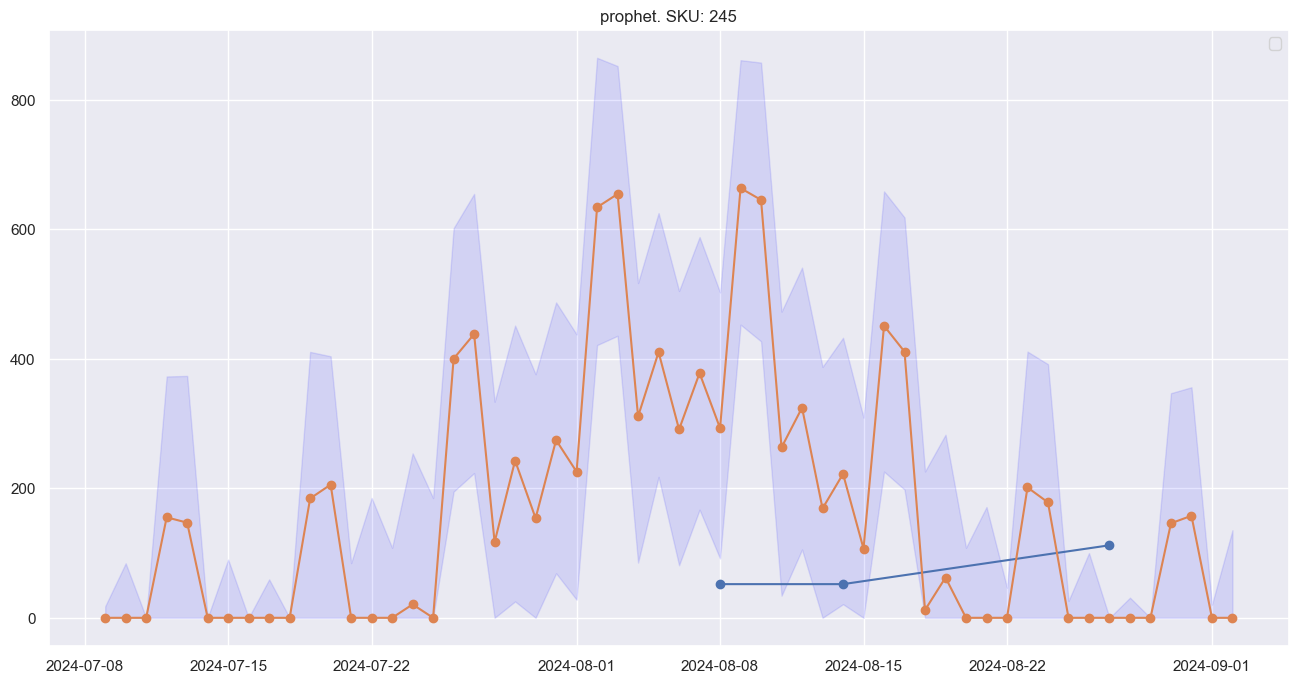

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


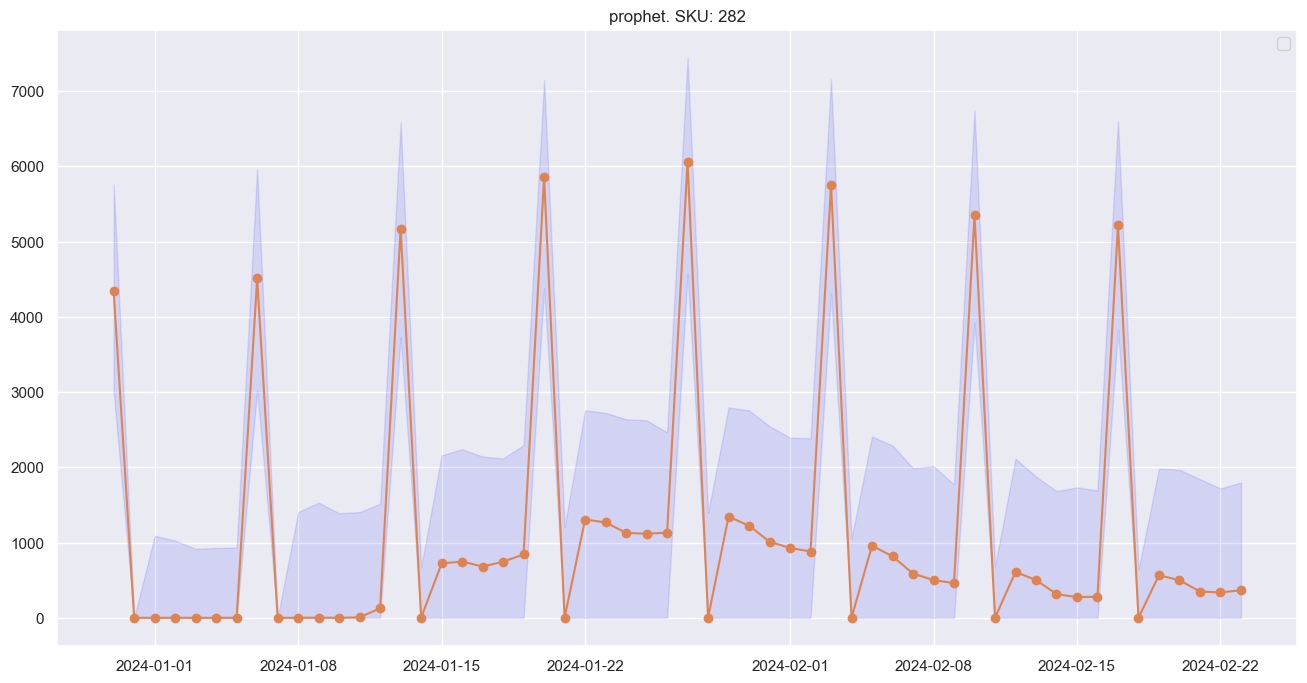

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


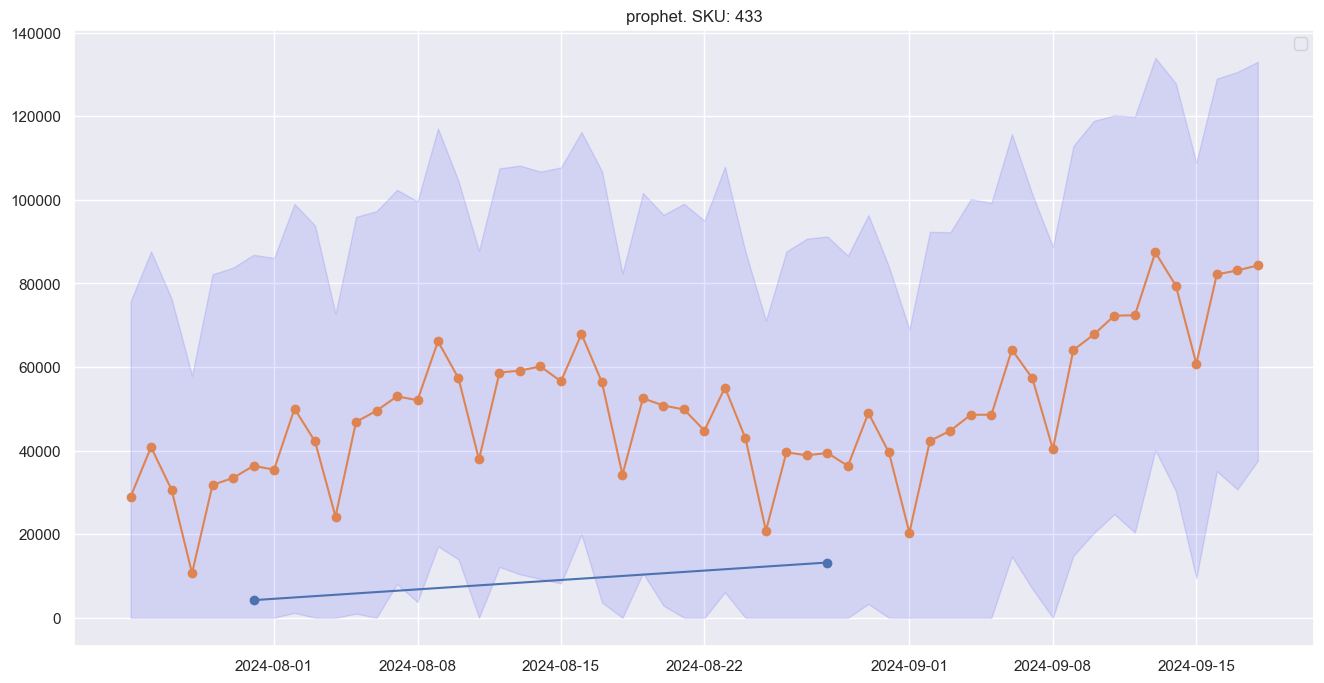

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


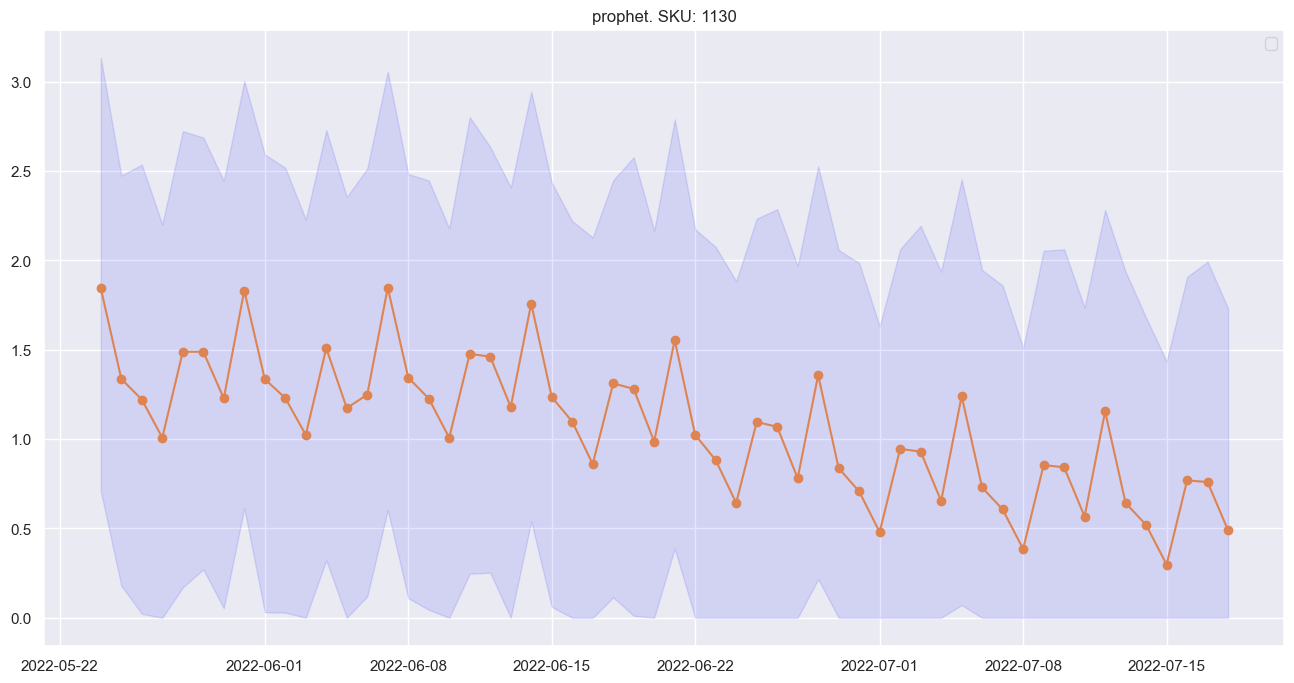

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


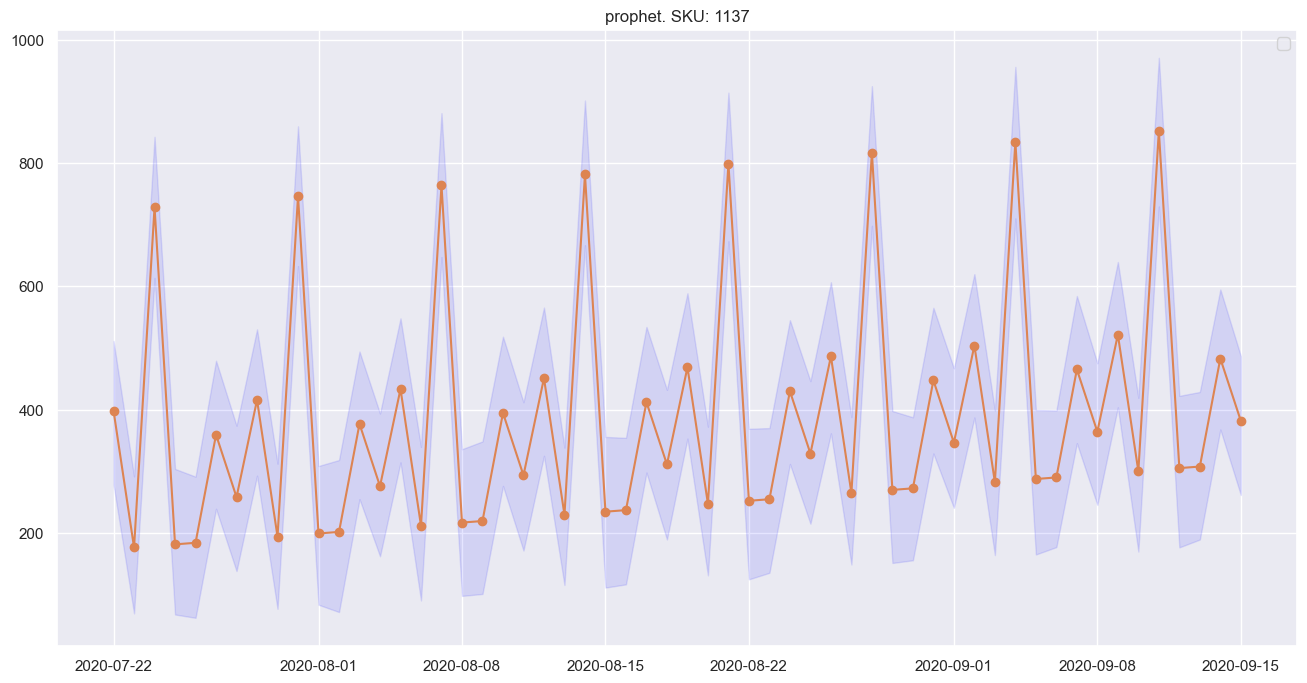

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


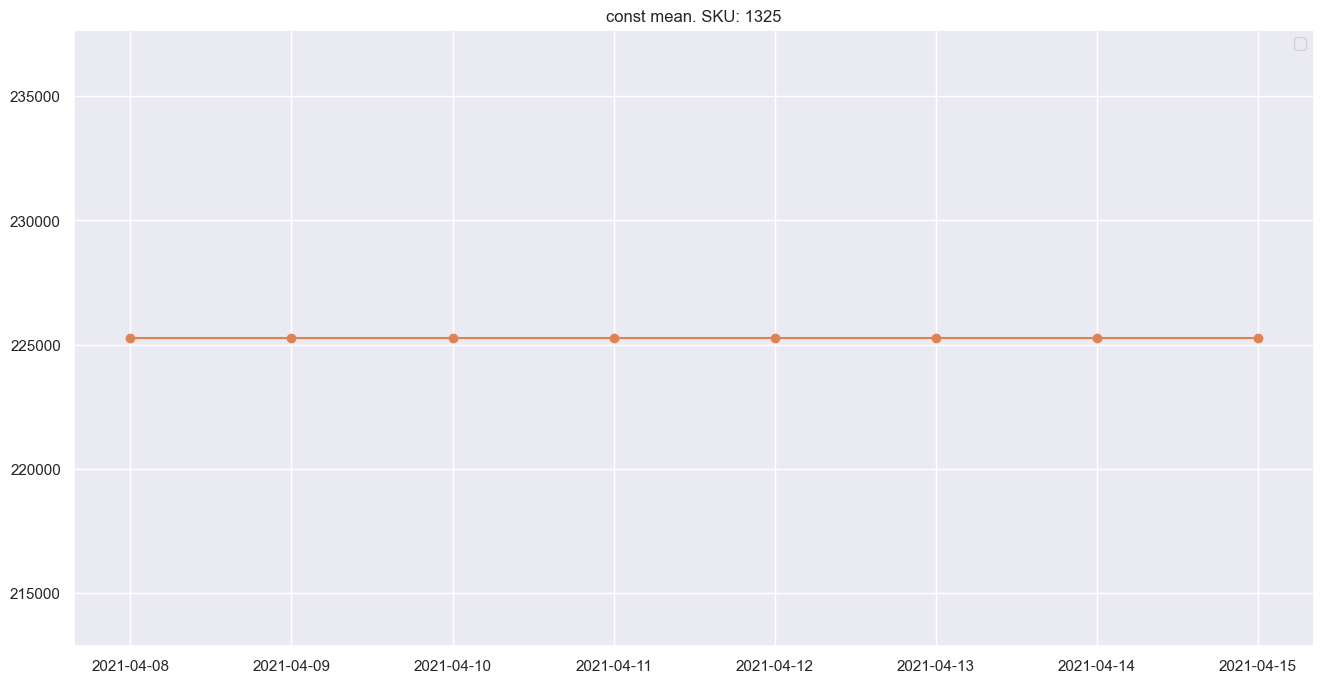

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


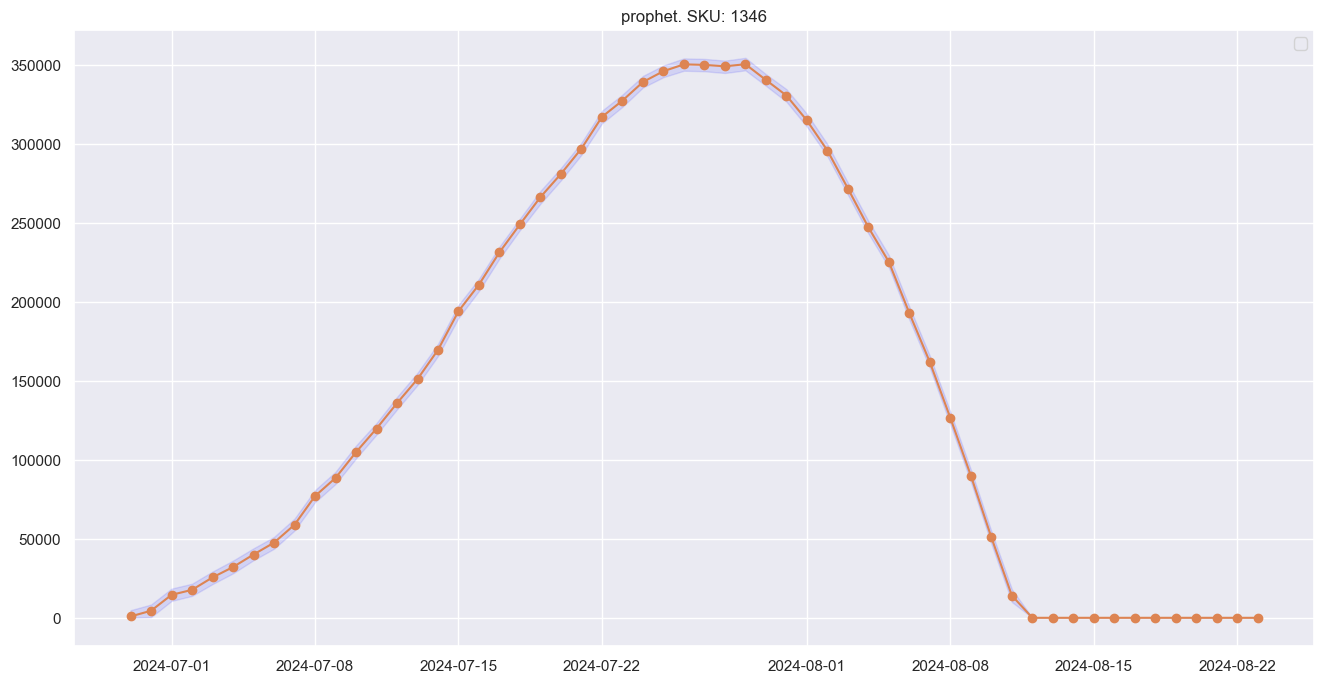

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


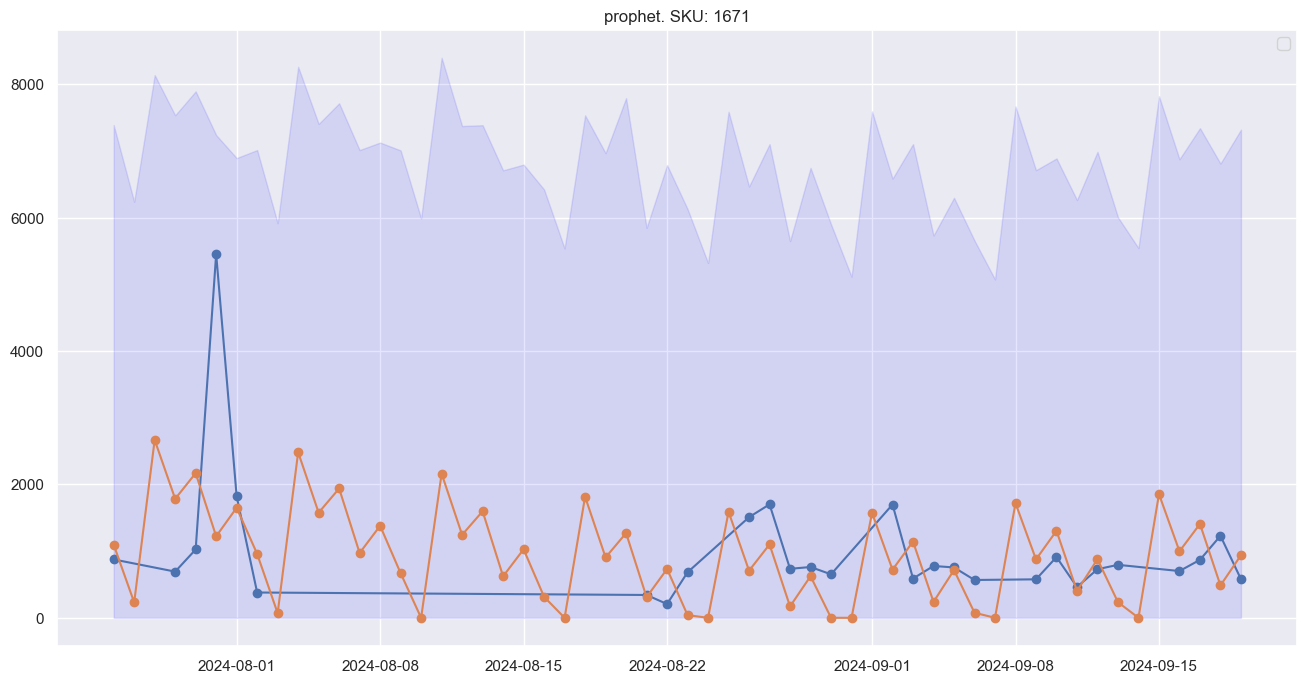

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


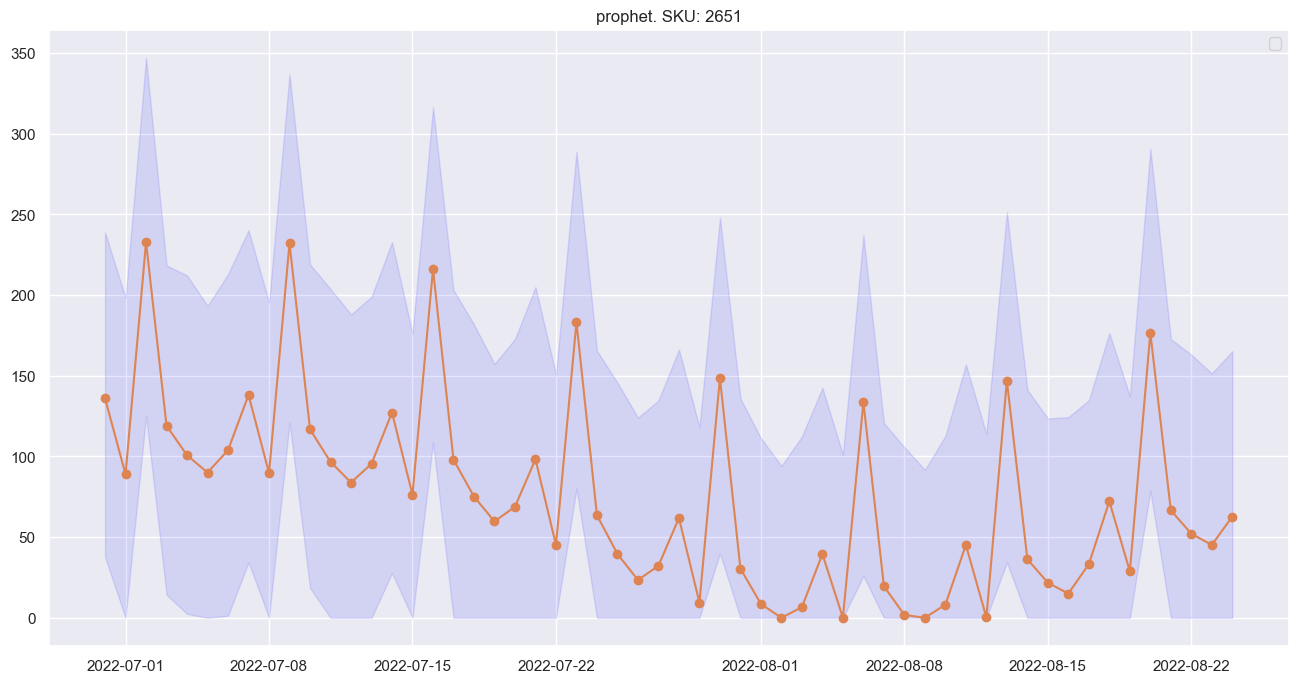

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


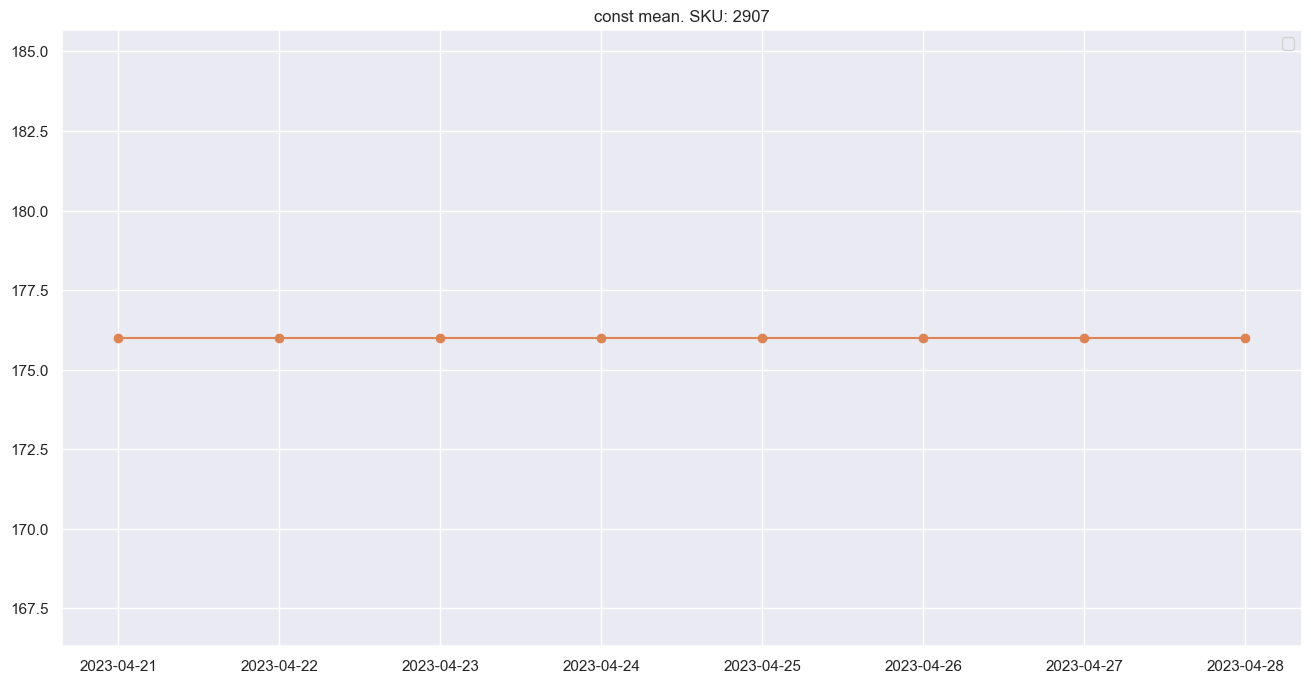

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_9861/1610924051.py:61: UserWarning: Legend does not support handles for datetime64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(forecast["ds"].values, forecast["yhat"].values)


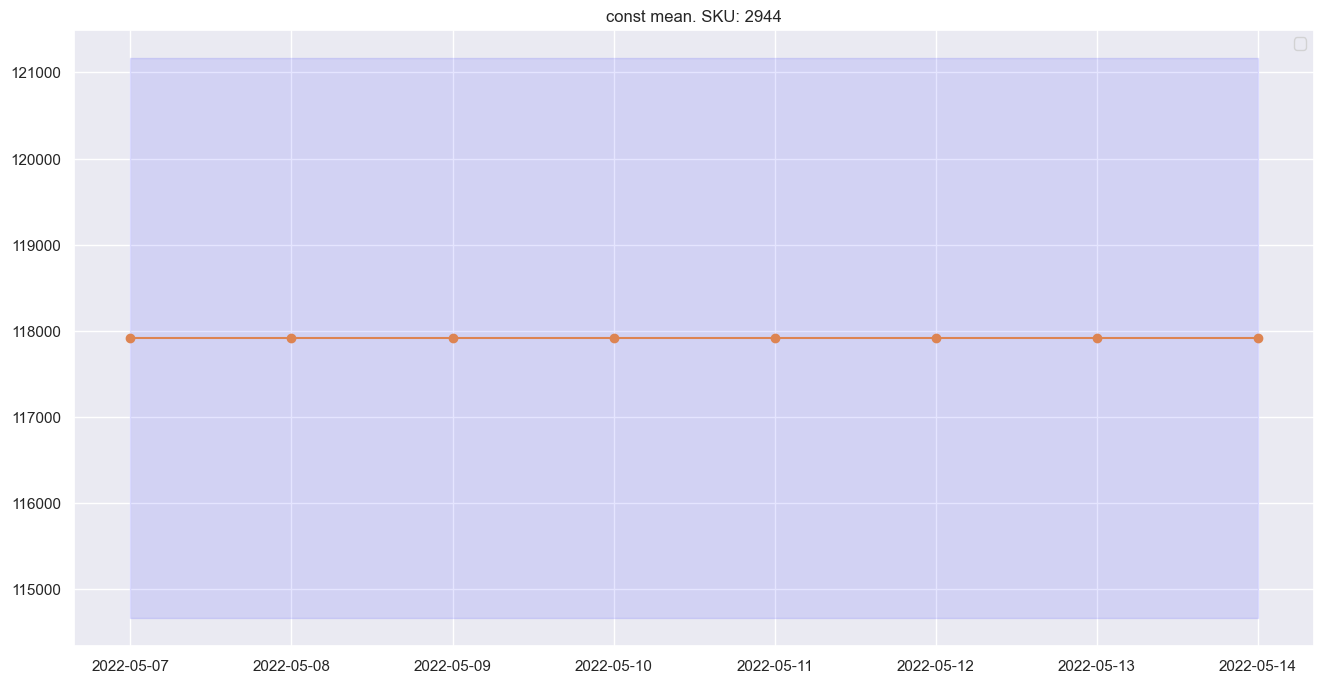

In [94]:
%time

#def fit_predict(ci_alphas: List[float] = [0.2, 0.5, 0.8]):

#i = 0
forecast_all = []
for sku, df_sku in train.groupby("sku"):
    #if i > 10:
    #    break
    model_type = None
    
    if df_sku.shape[0] < 10:
        model_type = "const mean"
        const_forecast = df_sku["sales"].mean()

        # compute residuals for leave-one-out strategy
        residuals = []
        for ind, row in df_sku.iterrows():
            loo_forecast = df_sku[df_sku.index.values != ind]["sales"].mean()
            loo_residual = row["sales"] - loo_forecast

            residuals.append(loo_residual)
            
        ci_lengths = np.percentile(residuals, [x * 100 for x in ci_alphas])
        alpha_ci_length = dict(zip(ci_alphas, ci_lengths))
        
        test_start_date = df_sku["date"].iloc[-1]
        forecast = pd.DataFrame({"ds": [test_start_date + pd.Timedelta(days=i) for i in range(1, 9)], "yhat": const_forecast * 8})

        forecast[f"yhat_lower"] = forecast["yhat"] - alpha_ci_length[alpha]
        forecast[f"yhat_upper"] = forecast["yhat"] + alpha_ci_length[alpha]
        
        #for alpha in ci_alphas:
        #    forecast[f"yhat_low_{alpha}"] = forecast["yhat"] - alpha_ci_length[alpha]
        #    forecast[f"yhat_high_{alpha}"] = forecast["yhat"] + alpha_ci_length[alpha]
    else:
        model_type = "prophet"
        model = Prophet(interval_width=ci_alphas[-1])
        model.add_country_holidays(country_name='IL')
    
        train_prophet = df_sku[["date", "sales"]]
        train_prophet.columns = ["ds", "y"]
        model.fit(train_prophet)
    
        future = model.make_future_dataframe(periods=8*7)
        forecast = model.predict(future)
        forecast = forecast[forecast["ds"] > train_prophet["ds"].max()]
        #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    for c in ["yhat", "yhat_lower", "yhat_upper"]:
        forecast[c] = forecast[c].apply(lambda x: max(x, 0))
    
    forecast["sku"] = sku
    forecast_all.append(forecast)

    if sku in skus:
        plt.figure(figsize=(16, 8))
        plt.plot(test[test["sku"] == sku]["date"].values, test[test["sku"] == sku]["sales"].values, label="target", marker="o")
        plt.plot(forecast["ds"].values, forecast["yhat"].values, label="Prophet predict", marker="o")
        plt.fill_between(forecast["ds"].values, forecast["yhat_lower"].values, forecast["yhat_upper"].values, alpha=0.1, color="blue")
        plt.legend(forecast["ds"].values, forecast["yhat"].values)
        plt.title(f"{model_type}. SKU: {sku}")
        plt.show()

    #i += 1
        

In [95]:
len(forecast_all)

2836

In [96]:
forecast_all_pd = pd.concat(forecast_all)

In [97]:
forecast_all_pd.shape[0]

95360

In [98]:
forecast_all_pd.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (observed),Independence Day (observed)_lower,Independence Day (observed)_upper,Pesach,Pesach_lower,Pesach_upper,Rosh Hashanah,Rosh Hashanah_lower,Rosh Hashanah_upper,Seventh day of Pesach,Seventh day of Pesach_lower,Seventh day of Pesach_upper,Shavuot,Shavuot_lower,Shavuot_upper,Simchat Torah / Shemini Atzeret,Simchat Torah / Shemini Atzeret_lower,Simchat Torah / Shemini Atzeret_upper,Sukkot,Sukkot_lower,Sukkot_upper,Yom Kippur,Yom Kippur_lower,Yom Kippur_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,sku
85,2024-04-19,-844.523560,0.0,447.771246,-844.523560,-844.523560,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.437216,221.437216,221.437216,0.000000e+00,0.000000e+00,0.000000e+00,-143.391607,-143.391607,-143.391607,364.828823,364.828823,364.828823,0.0,0.0,0.0,0.000000,0
86,2024-04-20,-845.699917,0.0,0.000000,-845.699917,-845.699917,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-712.693693,-712.693693,-712.693693,0.000000e+00,0.000000e+00,0.000000e+00,-997.125623,-997.125623,-997.125623,284.431930,284.431930,284.431930,0.0,0.0,0.0,0.000000,0
87,2024-04-21,-846.876275,0.0,1084.044661,-846.876275,-846.876275,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,847.644692,847.644692,847.644692,0.000000e+00,0.000000e+00,0.000000e+00,641.266879,641.266879,641.266879,206.377814,206.377814,206.377814,0.0,0.0,0.0,0.768417,0
88,2024-04-22,-848.052633,0.0,362.220855,-848.052633,-848.052633,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175.014719,175.014719,175.014719,0.000000e+00,0.000000e+00,0.000000e+00,42.928862,42.928862,42.928862,132.085857,132.085857,132.085857,0.0,0.0,0.0,0.000000,0
89,2024-04-23,-849.228990,0.0,325.099333,-849.228990,-849.228990,0.0,0.0,0.0,0.0,0.0,0.0,9.438042e-10,9.438042e-10,9.438042e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.499074,101.499074,101.499074,9.438042e-10,9.438042e-10,9.438042e-10,38.615518,38.615518,38.615518,62.883556,62.883556,62.883556,0.0,0.0,0.0,0.000000,0


In [112]:
test_w_forecast = test.copy()
test_w_forecast = test.merge(forecast_all_pd[["ds", "sku", "yhat"]].rename(columns={"ds": "date"}), on=["date", "sku"], how="left")

In [113]:
test.shape[0], test_w_forecast.shape[0]

(6695, 6695)

In [116]:
test_w_forecast.head()

,sku,date,sales,target,yhat,err,abs_err,max_val,rel_err
0,1,2024-08-02,235.0,235.0,0.000000,-235.000000,235.000000,235.0,-1.000000
1,1,2024-08-13,115.0,115.0,0.000000,-115.000000,115.000000,115.0,-1.000000
2,1,2024-08-18,375.0,375.0,0.000000,-375.000000,375.000000,375.0,-1.000000
3,1,2024-08-22,975.0,975.0,297.077816,-677.922184,677.922184,975.0,-0.695305
4,1,2024-08-25,675.0,675.0,0.000000,-675.000000,675.000000,675.0,-1.000000


In [122]:
calc_quality(test_w_forecast, "yhat")

,wape,wape_max,bias,hist_bias_-inf_-0.2,hist_bias_-0.2_0.2,hist_bias_0.2_inf
0,107.560837,71.463314,11.243516,36.639283,8.334578,45.123226


### Prophet from module

In [8]:
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

from model import calc_quality, fit_predict
from config import Config

Importing plotly failed. Interactive plots will not work.


In [7]:
df_daily = pd.read_parquet("../data/data_daily_sparse.parquet")
df_weekly = pd.read_parquet("../data/data_weekly.parquet")

In [9]:
config = Config(frequency="weekly")

In [19]:
predict_list = []
for val_week in val_weeks:
    print(val_week)
    train = df_daily[df_daily["date"] < val_week]
    test = df_daily[df_daily["date"].between(val_week, val_week + pd.Timedelta(days = config.horizon_days))]

    predict_vw = fit_predict(config, train, test)
    predict_vw["val_week"] = val_week
    predict_list.append(predict_vw)

predict = pd.concat(predict_list, axis=0)

2025-07-22 00:00:00
2025-05-27 00:00:00
2025-04-01 00:00:00
2025-02-04 00:00:00
2024-12-10 00:00:00
2024-10-15 00:00:00
2024-08-20 00:00:00


In [ ]:
#!mkdir "../predicts"

In [20]:
predict.to_parquet("../predicts/prophet_daily.parquet")

In [24]:
predict.head()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num,yhat,yhat_lower,yhat_upper,val_week,target,err,abs_err,max_val,rel_err
0,0,2025-07-24,66.0,66.000000,66.0,66.000000,66.0,283.142857,3964.000,646.0,30,7,0.0,NaN,NaN,2025-07-22,66.0,-66.0,66.0,66.0,-1.0
1,0,2025-09-16,0.0,0.000000,0.0,33.000000,66.0,264.266667,3964.000,646.0,38,9,0.0,NaN,NaN,2025-07-22,0.0,0.0,0.0,0.0,NaN
2,1,2025-07-22,95.0,172.272727,1895.0,407.967742,12647.0,712.632284,110458.004,4295.0,30,7,0.0,0.0,2337.850092,2025-07-22,95.0,-95.0,95.0,95.0,-1.0
3,1,2025-07-24,160.0,179.090909,1970.0,397.733333,11932.0,709.089769,110618.004,170.0,30,7,0.0,0.0,2472.648858,2025-07-22,160.0,-160.0,160.0,160.0,-1.0
4,1,2025-07-25,85.0,141.818182,1560.0,368.400000,11052.0,705.114675,110703.004,1407.0,30,7,0.0,0.0,2003.264629,2025-07-22,85.0,-85.0,85.0,85.0,-1.0


In [25]:
predict_weeks = predict.set_index("date").groupby("sku").resample("W-SUN", label="left", closed="left")[["sales", "yhat"]].sum().reset_index()

display(calc_quality(predict_weeks, predict_colname="yhat"))
display(calc_quality(predict_weeks.groupby("sku")[["sales", "yhat"]].sum(), predict_colname="yhat"))

,wape,wape_max,bias,hist_bias_-inf_-0.2,hist_bias_-0.2_0.2,hist_bias_0.2_inf
0,139.622552,82.924335,15.796908,18.318799,4.029488,15.436483


,wape,wape_max,bias,hist_bias_-inf_-0.2,hist_bias_-0.2_0.2,hist_bias_0.2_inf
0,78.186403,56.661582,15.971425,20.658381,9.271078,6.9869


In [39]:
%reload_ext autoreload

In [40]:
from model import calc_quality, fit_predict
from config import Config

In [41]:
config.frequency = "week"

In [43]:
predict_list_weekly = []
for val_week in val_weeks:
    print(val_week)
    train = df_weekly[df_weekly["date"] < val_week]
    test = df_weekly[df_weekly["date"].between(val_week, val_week + pd.Timedelta(days = config.horizon_days))]

    predict_vw = fit_predict(config, train, test)
    predict_vw["val_week"] = val_week
    predict_list.append(predict_vw)

predict_weeky = pd.concat(predict_list_weekly, axis=0)
predict_weeky.to_parquet("../predicts/prophet_weekly.parquet")

2025-07-22 00:00:00
2025-05-27 00:00:00
2025-04-01 00:00:00
2025-02-04 00:00:00
2024-12-10 00:00:00
2024-10-15 00:00:00
2024-08-20 00:00:00


ValueError: No objects to concatenate

In [44]:
predict_vw.shape[0]

22769

In [45]:
predict_vw.head()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num,predict,lower_0.2,lower_0.5,lower_0.8,upper_0.2,upper_0.5,upper_0.8,val_week
0,0,2024-08-25,0.0,0.0,0.0,0.0,0.0,134.264151,7116.0,0.0,34,8,104.541385,0.0,0.0,0.0,286.715284,605.771877,967.760249,2024-08-20
1,0,2024-09-01,0.0,0.0,0.0,0.0,0.0,134.264151,7116.0,0.0,35,9,61.599112,0.0,0.0,0.0,243.723843,495.664121,951.625256,2024-08-20
2,0,2024-09-08,0.0,0.0,0.0,0.0,0.0,125.849057,6670.0,446.0,36,9,0.000000,0.0,0.0,0.0,96.438857,454.407039,807.015221,2024-08-20
3,0,2024-09-15,0.0,0.0,0.0,0.0,0.0,125.849057,6670.0,0.0,37,9,0.000000,0.0,0.0,0.0,115.702363,422.858081,756.952493,2024-08-20
4,0,2024-09-22,0.0,0.0,0.0,0.0,0.0,125.849057,6670.0,0.0,38,9,0.000000,0.0,0.0,0.0,150.592016,451.370428,854.058580,2024-08-20


In [46]:
len(predict_list)

14

In [47]:
predict_list_weekly = predict_list[7:]
len(predict_list_weekly)

7

In [48]:
predict_weeky = pd.concat(predict_list_weekly, axis=0)
predict_weeky.to_parquet("../predicts/prophet_weekly.parquet")

In [50]:
display(df_weekly[df_weekly["sku"] == 0].head())
predict_weeky[predict_weeky["sku"] == 0].head()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num
0,0,2020-01-26,186.0,186.0,186.0,186.0,186.0,186.0,186.0,NaN,4,1
1,0,2020-02-02,0.0,93.0,186.0,93.0,186.0,93.0,186.0,NaN,5,2
2,0,2020-02-09,0.0,62.0,186.0,62.0,186.0,62.0,186.0,NaN,6,2
3,0,2020-02-16,0.0,46.5,186.0,46.5,186.0,46.5,186.0,NaN,7,2
4,0,2020-02-23,0.0,0.0,0.0,37.2,186.0,37.2,186.0,NaN,8,2


,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num,predict,lower_0.2,lower_0.5,lower_0.8,upper_0.2,upper_0.5,upper_0.8,val_week
0,0,2025-07-27,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,30,7,6.767687,0.0,0.0,0.0,164.449842,407.647776,852.975146,2025-07-22
1,0,2025-08-03,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,31,8,7.962047,0.0,0.0,0.0,174.028398,414.774707,898.979333,2025-07-22
2,0,2025-08-10,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,32,8,0.000000,0.0,0.0,0.0,157.722967,426.890048,844.744132,2025-07-22
3,0,2025-08-17,0.0,0.0,0.0,8.25,66.0,74.792453,3964.0,0.0,33,8,12.855160,0.0,0.0,0.0,183.407118,444.177521,817.685413,2025-07-22
4,0,2025-08-24,0.0,0.0,0.0,8.25,66.0,74.792453,3964.0,0.0,34,8,45.082826,0.0,0.0,0.0,213.569493,444.317390,869.951242,2025-07-22


In [53]:
display(calc_quality(predict_weeky, predict_colname="predict"))
display(calc_quality(predict_weeky.groupby("sku")[["sales", "predict"]].sum(), predict_colname="predict"))

,wape,wape_max,bias,hist_bias_-inf_-0.2,hist_bias_-0.2_0.2,hist_bias_0.2_inf
0,151.368078,86.474756,10.143137,6.19601,1.279817,29.395308


,wape,wape_max,bias,hist_bias_-inf_-0.2,hist_bias_-0.2_0.2,hist_bias_0.2_inf
0,38.432475,34.568248,10.314528,11.823984,10.648304,65.334229


### auto ARIMA

In [8]:
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

from model import calc_quality, fit_predict
from config import Config

Importing plotly failed. Interactive plots will not work.


In [12]:
df_daily = pd.read_parquet("../data/data_daily_sparse.parquet")
df_weekly = pd.read_parquet("../data/data_weekly.parquet")

In [9]:
config = Config(frequency="week")

In [10]:
from pmdarima import auto_arima

In [11]:
config.heuristics_min_rows = 3

In [16]:
predict_list_weekly = []
for val_week in val_weeks[:1]:
    print(val_week)
    train = df_weekly[df_weekly["date"] < val_week]
    test = df_weekly[df_weekly["date"].between(val_week, val_week + pd.Timedelta(days = config.horizon_days))]

2025-07-22 00:00:00


In [67]:
sku_sample_list = [*np.random.choice(train["sku"].unique(), 5), 1671]
sku_sample_list

[np.int64(1141),
 np.int64(2760),
 np.int64(1213),
 np.int64(373),
 np.int64(285),
 1671]

In [ ]:
from config import get_frequency_params
from typing import List
import os

model_path = "../models/arima"
ci_levels = [config.ci_levels[-1]]
horizon_period, freq_mult, freq_name = get_frequency_params(config.frequency, config.horizon_days)

#models_all = {}
forecast_all: List[pd.DataFrame] = []
for sku, df_sku in train.groupby("sku"):    
    if df_sku.shape[0] < config.heuristics_min_rows:
        const_forecast = df_sku["sales"].mean()

        # compute confidence intervals from residuals for leave-one-out strategy
        residuals = []
        for ind, row in df_sku.iterrows():
            loo_forecast = df_sku[df_sku.index.values != ind]["sales"].mean()
            loo_residual = row["sales"] - loo_forecast

            residuals.append(loo_residual)

        ci_lengths = np.percentile(residuals, [x * 100 for x in ci_levels])
        level_ci_length = dict(zip(ci_levels, ci_lengths))

        test_start_date = df_sku["date"].iloc[-1]
        forecast = pd.DataFrame(
            {
                "data": [test_start_date + pd.Timedelta(days=i * freq_mult) for i in range(1, horizon_period + 1)],
                "predict": const_forecast * horizon_period,
            }
        )

        for level in ci_levels:
            forecast[f"lower_{level}"] = forecast["predict"] - level_ci_length[level]
            forecast[f"upper_{level}"] = forecast["predict"] + level_ci_length[level]

        forecast["model_type"] = "const_mean"
    else:
        model = auto_arima(
        	train["sales"],
        	#exogenous=train[features],
        	trace=True,
        	error_action="ignore",
            seasonal=True,
            stepwise=False,
        	suppress_warnings=True,
            start_p=0, start_q=0, start_P=0, start_Q=0 ,
            max_p=5, max_q=5, max_P=5, max_Q=5,
            m=52,
        )

        #models_all[sku] = model
        with open(f"model_{sku}.json", "w") as f:
            json.dump(model.get_params(), f)

        forecast: pd.DataFrame = None  # type: ignore
        for level in ci_levels:
            forecast_level, ci = model.predict(n_periods=test.shape[0], return_conf_int=True, alpha=1 - level)
            forecast_level = forecast_level[forecast_level["date"] > train["date"].max()]
            forecast_level = forecast_level.rename(
                columns={"ds": "date", "yhat": "predict", "yhat_lower": f"lower_{level}", "yhat_upper": f"upper_{level}"}
            )

            if forecast is None:
                forecast = forecast_level
            else:
                forecast = forecast.merge(forecast_level[["date", f"lower_{level}", f"upper_{level}"]], on="date")

        forecast["model_type"] = "ARIMA"


    print(sku, df_sku.shape[0]) 
    plt.figure(figsize=(16, 8))
    plt.plot(df_sku["date"].values, df_sku["sales"].values, label="train sales")
    plt.plot(forecast["date"].values, forecast["sales"].values, label="test sales")
    plt.plot(forecast["date"].values, forecast["predict"].values, label="test predict")
    plt.legend()
    plt.title(f"SKU {sku}, shape {dfu_sku.shape[0]}, type {forecast["model_type"].iloc[0]}")
    plt.show()

    forecast["sku"] = sku
    forecast_all.append(forecast)

 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=17661639.551, Time=6.33 sec


In [ ]:
predict_weeky = pd.concat(forecast_all, axis=0)
predict_weeky.to_parquet("../predicts/auto_arima_weekly.parquet")

In [1]:
sku

NameError: name 'sku' is not defined

### Arima: learn hyperparamenters on one sku or sum of all skus

#### auto arima

In [110]:
sku

285

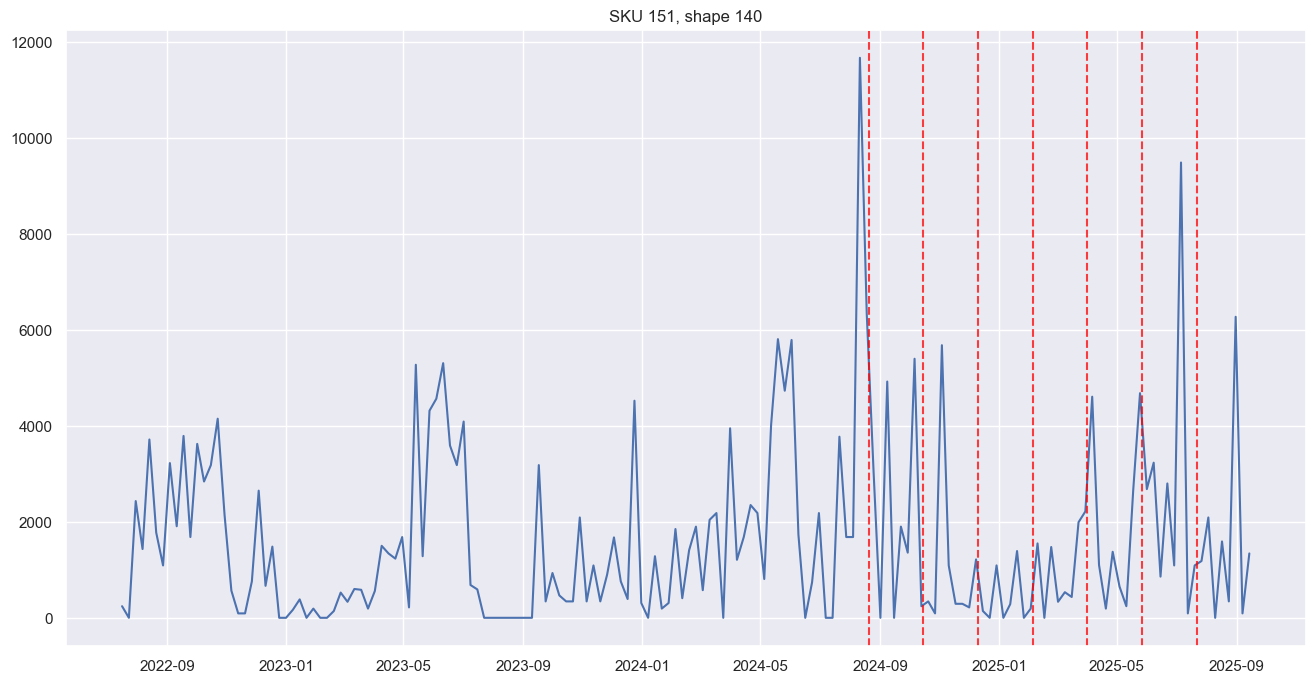

In [112]:
plt.figure(figsize=(16, 8))
plt.plot(df_weekly[df_weekly["sku"] == 285]["date"].values, df_weekly[df_weekly["sku"] == 285]["sales"].values)
for vw in val_weeks:
    plt.axvline(vw, linestyle="--", color="red", alpha=0.75)
    
plt.title(f"SKU 151, shape {df_weekly[(df_weekly["sku"] == 285) & (df_weekly["sales"] > 0)].shape[0]}")
plt.show()

optimize parameters on SKU with max n points and on sum data

In [85]:
df_sku_sizes = df_weekly[df_weekly["sales"] > 0].groupby("sku").size()
df_sku_sizes[df_sku_sizes == df_sku_sizes.max()]

sku
28    299
dtype: int64

In [87]:
df_sku_sizes.sort_values().tail()

sku
247     296
119     296
1197    297
151     298
28      299
dtype: int64

In [105]:
df_sum_weekly = df_weekly.groupby("date").sum()

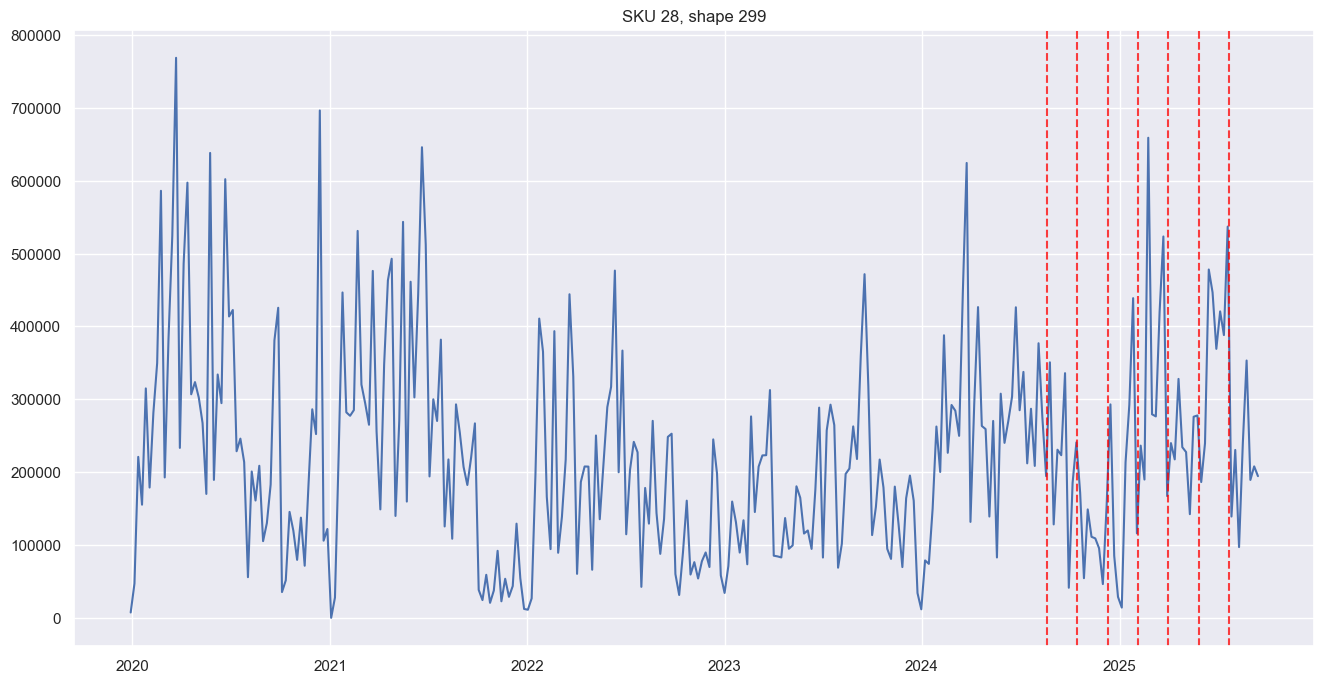

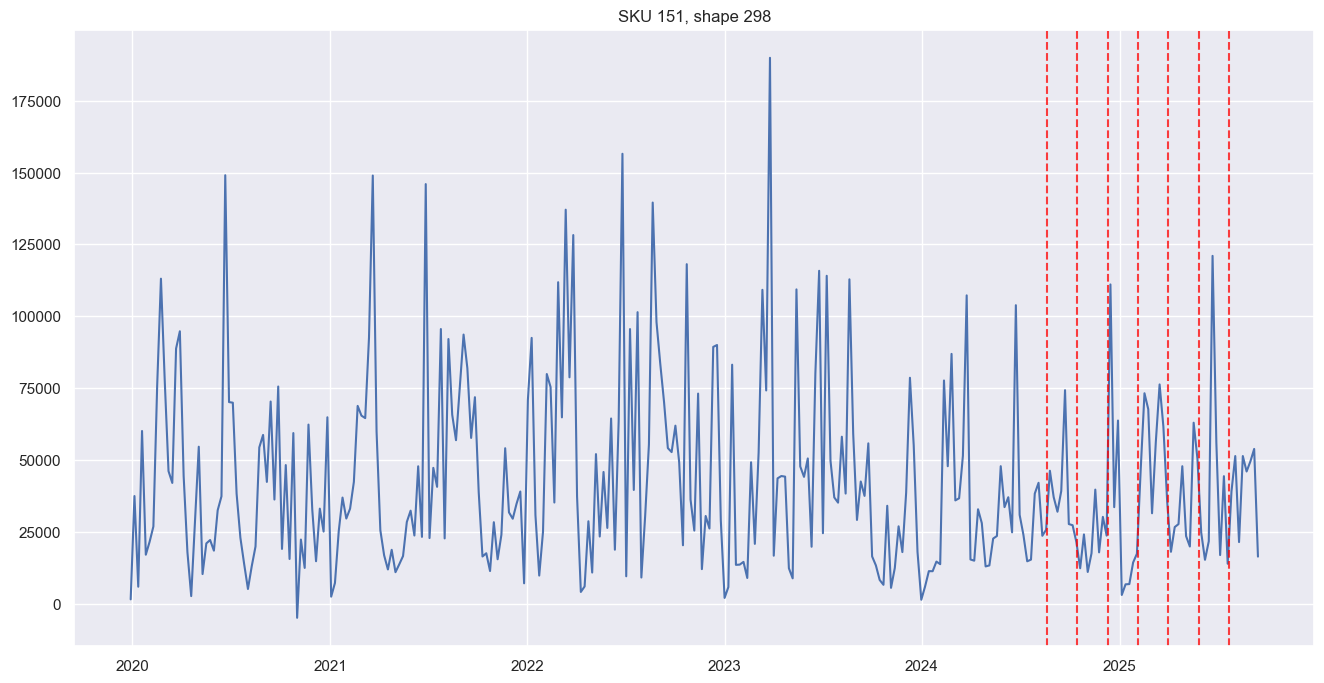

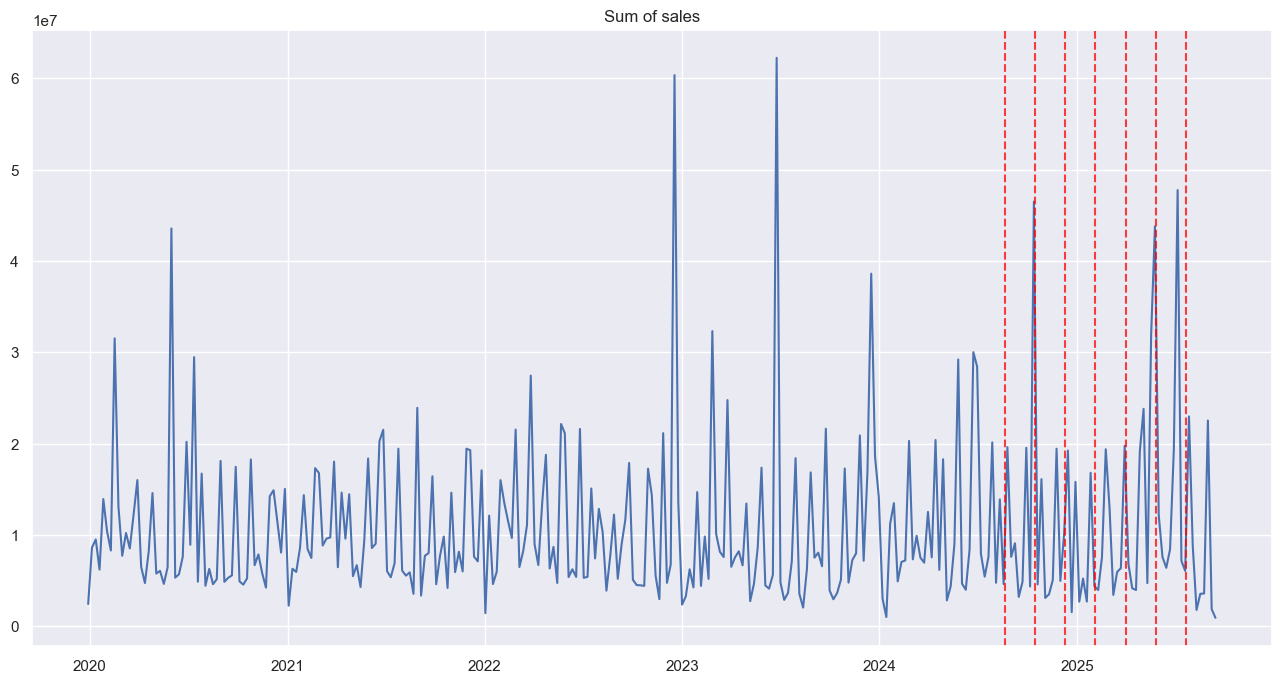

In [98]:
plt.figure(figsize=(16, 8))
plt.plot(df_weekly[df_weekly["sku"] == 28]["date"].values, df_weekly[df_weekly["sku"] == 28]["sales"].values)
for vw in val_weeks:
    plt.axvline(vw, linestyle="--", color="red", alpha=0.75)
    
plt.title(f"SKU 28, shape {df_weekly[(df_weekly["sku"] == 28) & (df_weekly["sales"] > 0)].shape[0]}")
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(df_weekly[df_weekly["sku"] == 151]["date"].values, df_weekly[df_weekly["sku"] == 151]["sales"].values)
for vw in val_weeks:
    plt.axvline(vw, linestyle="--", color="red", alpha=0.75)
    
plt.title(f"SKU 151, shape {df_weekly[(df_weekly["sku"] == 151) & (df_weekly["sales"] > 0)].shape[0]}")
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(df_sum.index.values, df_sum["sales"].values)
for vw in val_weeks:
    plt.axvline(vw, linestyle="--", color="red", alpha=0.75)
    
plt.title("Sum of sales")
plt.show()

In [99]:
sku = 28

model_sku = auto_arima(
    train[train["sku"] == sku]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0 ,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    n_jobs=-1,
)

/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7748.850, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7691.612, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7712.670, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8102.335, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=7683.695, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7681.867, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=7660.844, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=7662.375, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7662.528, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7682.776, Time=0.05 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=7664.374, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=7674.372, Time=0.06 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 0.465 seconds


In [17]:
sku = 28

model_sku = auto_arima(
    train[train["sku"] == sku]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0 ,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    m=52,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7748.850, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=7664.045, Time=0.61 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7681.491, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=8102.335, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=7691.612, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=7665.584, Time=6.75 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=7659.794, Time=1.53 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=7661.851, Time=1.11 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=7657.658, Time=9.17 sec
 ARIMA(1,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=36.51 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=16.70 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=7659.760, Time=6.67 sec
 ARIMA(1,0,0)(3,0,0)[52] intercept   : AIC=7667.364, Time=32.23 sec
 ARIMA(1,0,0)(3,0,2)[52] intercept   : AIC=7659.691, Time=38.17 sec
 ARIMA(0,0,0)(2,0,1)[52] 

In [18]:
sku = 151

model_sku = auto_arima(
    train[train["sku"] == sku]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=1, start_q=1, start_P=1, start_Q=1,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    m=52,
    n_jobs=-1,
)

/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=4.48 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6886.686, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6850.539, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6849.361, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7175.190, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=6878.039, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=6850.858, Time=1.59 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=6847.146, Time=3.46 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=6849.133, Time=4.89 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=6845.219, Time=10.09 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=6847.215, Time=15.24 sec
 ARIMA(0,0,1)(0,0,4)[52] intercept   : AIC=inf, Time=30.66 sec
 ARIMA(0,0,1)(1,0,4)[52] intercept   : AIC=inf, Time=32.82 sec
 ARIMA(0,0,0)(0,0,3)[52] intercept   : AIC=6847.756, Time=9.25 sec
 ARIMA(1,0,1)(0,0,3)[52] inter

In [29]:
dir(model_sku)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_exog',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fit',
 '_get_class_level_metadata_request_values',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params_html',
 '_html_repr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_params',
 '_warn_for_older_version',
 'aic',
 'aicc',
 'arima_res_',
 'arparams',
 'arroots',
 'bic',
 'bse',
 'conf_int',
 'df_model',
 'df_resid',


In [30]:
model_sku.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 0, 52),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [31]:
import json

json.dumps(model_sku.get_params())

'{"maxiter": 50, "method": "lbfgs", "order": [4, 0, 0], "out_of_sample_size": 0, "scoring": "mse", "scoring_args": {}, "seasonal_order": [1, 0, 0, 52], "start_params": null, "suppress_warnings": true, "trend": null, "with_intercept": true}'

In [22]:
200*2000 / 60 / 60

111.11111111111111

In [19]:
df_sum_weekly = df_weekly.groupby("date").sum()
df_sum_weekly = df_sum_weekly.reset_index(drop=False)
df_sum_weekly.head()

,date,sku,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num
0,2019-12-29,268077,2.428226e+06,2.428226e+06,2.428226e+06,2.428226e+06,2.428226e+06,2.428226e+06,2.428226e+06,0.0,10296,2376
1,2020-01-05,527202,8.601541e+06,9.278622e+06,1.102977e+07,9.278622e+06,1.102977e+07,9.278622e+06,1.102977e+07,0.0,442,442
2,2020-01-12,666413,9.490912e+06,1.092458e+07,2.052068e+07,1.092458e+07,2.052068e+07,1.092458e+07,2.052068e+07,0.0,1158,579
3,2020-01-19,749531,6.192215e+06,9.494238e+06,2.671289e+07,9.494238e+06,2.671289e+07,9.494238e+06,2.671289e+07,0.0,1962,654
4,2020-01-26,972655,1.391637e+07,1.455579e+07,3.820104e+07,1.466547e+07,4.062926e+07,1.466547e+07,4.062926e+07,0.0,3228,807


In [107]:
model_sum = auto_arima(
    df_sum_weekly[df_sum_weekly["date"] < val_weeks[0]]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0 ,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    n_jobs=-1,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10139.903, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10141.282, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10141.083, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10405.475, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10143.919, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.080 seconds


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [20]:
model_sum = auto_arima(
    df_sum_weekly[df_sum_weekly["date"] < val_weeks[0]]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0 ,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    m=52
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=10139.903, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=10121.499, Time=0.76 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=10103.515, Time=1.27 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=10405.475, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=10141.083, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=10105.101, Time=1.90 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=10103.458, Time=5.12 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=10105.352, Time=7.09 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=inf, Time=10.53 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=inf, Time=16.66 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=10101.918, Time=3.81 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=10102.064, Time=0.97 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=10103.857, Time=5.04 sec
 ARIMA(0,0,0)(0,0,3)[52] intercept   : AIC=inf, Time=10.55 sec
 ARIMA(0,0,0)(1,0,1)

In [21]:
model_sum_new = auto_arima(
    df_sum_weekly[df_sum_weekly["date"] < val_weeks[0]]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=3, start_q=0, start_P=0, start_Q=0 ,
    max_p=5, max_q=2, max_P=2, max_Q=5,
    m=52
)

Failed to reload module 'model' from file '/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/src/model.py'
Traceback (most recent call last):
  File "/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 584, in superreload
    module = reload(module)
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 10

Performing stepwise search to minimize aic
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=10134.472, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=10139.903, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=10121.499, Time=0.72 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=10103.515, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=10405.475, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=10141.083, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=10105.101, Time=1.90 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=10103.458, Time=5.07 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=10105.352, Time=6.07 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=inf, Time=10.03 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=inf, Time=14.21 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=10101.918, Time=3.39 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=10102.064, Time=1.00 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=10103.857, Time=4.21 sec
 ARIMA(0,0,0)(0

In [ ]:
 ARIMA(4,0,0)(2,0,1)

In [23]:
sku = 28

model_sku = auto_arima(
    train[train["sku"] == sku]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=3, start_q=0, start_P=1, start_Q=0 ,
    max_p=5, max_q=2, max_P=3, max_Q=3,
    m=52,
)

Performing stepwise search to minimize aic
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=7648.110, Time=1.35 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7748.850, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=7664.045, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7681.491, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=8102.335, Time=0.00 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=7681.867, Time=0.04 sec
 ARIMA(3,0,0)(2,0,0)[52] intercept   : AIC=7649.909, Time=7.48 sec
 ARIMA(3,0,0)(1,0,1)[52] intercept   : AIC=7648.686, Time=1.92 sec
 ARIMA(3,0,0)(0,0,1)[52] intercept   : AIC=7652.070, Time=1.46 sec
 ARIMA(3,0,0)(2,0,1)[52] intercept   : AIC=7645.727, Time=13.30 sec
 ARIMA(3,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=57.22 sec
 ARIMA(3,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=34.51 sec
 ARIMA(3,0,0)(1,0,2)[52] intercept   : AIC=7648.119, Time=14.16 sec
 ARIMA(3,0,0)(3,0,0)[52] intercept   : AIC=7651.904, Time=27.01 sec
 ARIMA(3,0,0)(3,0,2)[52]

KeyboardInterrupt: 

In [25]:
sku = 28

model_sku = auto_arima(
    train[train["sku"] == sku]["sales"],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=False,
    suppress_warnings=True,
    start_p=4, start_q=0, start_P=2, start_Q=1,
    max_p=4, max_q=0, max_P=2, max_Q=1,
    d=0,
    m=52,
)

 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7748.850, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=7702.157, Time=0.64 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=7736.556, Time=0.42 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=7703.122, Time=1.38 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=7728.607, Time=5.82 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=16.80 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=7691.612, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=7661.851, Time=1.11 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=7664.045, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=7659.794, Time=1.64 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=7665.584, Time=6.66 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=7657.658, Time=9.53 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=7683.695, Time=0.03 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=7653.474, Time=1.14 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=7652.062, Time=0.93 sec

In [6]:
from scipy.stats import boxcox

In [7]:
train = df[df["date"] < val_weeks[0]]

NameError: name 'val_weeks' is not defined

In [13]:
sku = 28
train_sku_bc = boxcox(train[train["sku"] == sku]["sales"].values)

In [18]:
len(train_sku_bc)

2

In [20]:
train_sku_bc[1]

np.float64(0.469912900283804)

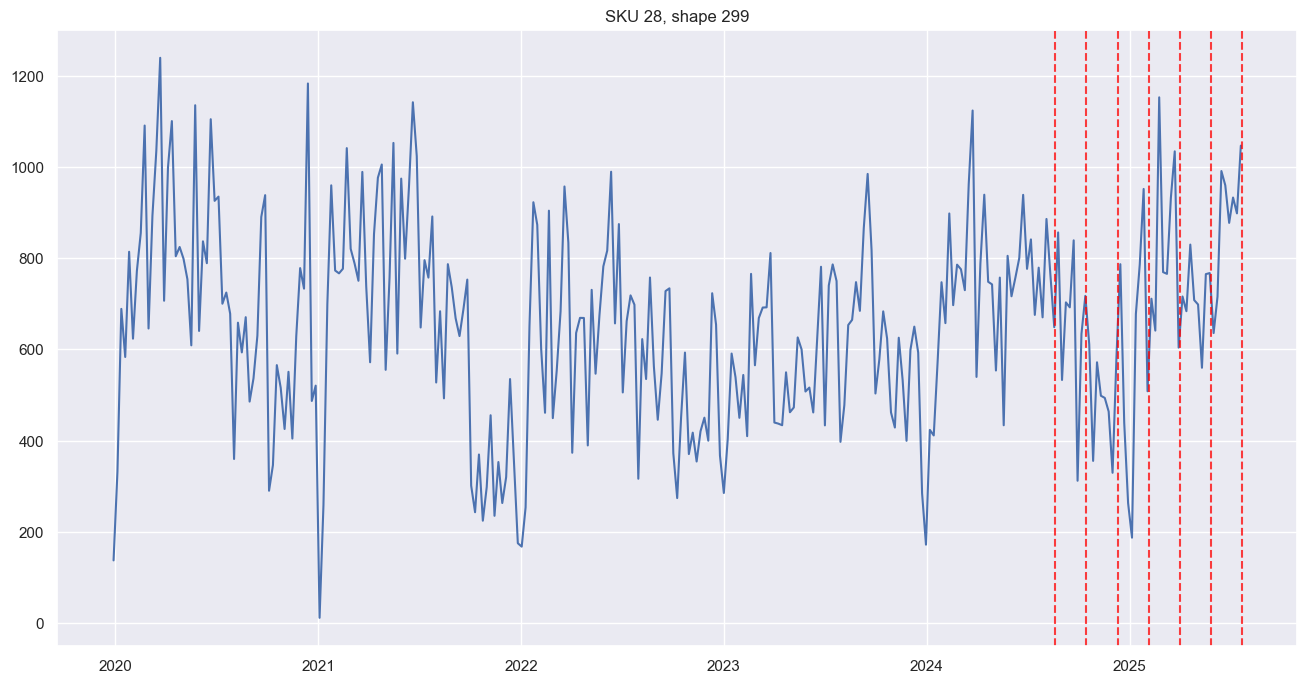

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(train[train["sku"] == sku]["date"].values, train_sku_bc[0])
#plt.plot(train[train["sku"] == sku]["date"].values, train[train["sku"] == sku]["sales"].values)

for vw in val_weeks:
    plt.axvline(vw, linestyle="--", color="red", alpha=0.75)
    
plt.title(f"SKU {sku}, shape {df[(df["sku"] == sku) & (df["sales"] > 0)].shape[0]}")
plt.show()

In [25]:
model_sku = auto_arima(
    train_sku_bc[0],
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    m=52,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3968.733, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3832.353, Time=2.64 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3864.564, Time=1.89 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4632.816, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3887.104, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=27.92 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3828.594, Time=4.26 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3847.680, Time=1.76 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=23.00 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=3840.624, Time=11.98 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=3842.396, Time=8.26 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=21.13 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=3902.295, Time=2.30 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=3815.027, Time=4.88 sec
 ARIMA(2,0,0)(0,0,1)[52] inter

#### statsmodels arima

In [30]:
import warnings
import itertools
import statsmodels.api as sm

p = d = q = range(0, 5)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        #try:
        mod = sm.tsa.statespace.SARIMAX(train_sku_bc[0],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        #except:
        #    continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 2, 52)
SARIMAX: (0, 0, 2) x (0, 0, 3, 52)
SARIMAX: (0, 0, 2) x (0, 0, 4, 52)
ARIMA(0, 0, 0)x(0, 0, 0, 52)12 - AIC:4617.863215247586
ARIMA(0, 0, 0)x(0, 0, 1, 52)12 - AIC:3583.526411402546
ARIMA(0, 0, 0)x(0, 0, 2, 52)12 - AIC:2727.2524672355366
ARIMA(0, 0, 0)x(0, 0, 3, 52)12 - AIC:1948.444763165382
ARIMA(0, 0, 0)x(0, 0, 4, 52)12 - AIC:1214.0953801609514
ARIMA(0, 0, 0)x(0, 1, 0, 52)12 - AIC:3208.7149526514704
ARIMA(0, 0, 0)x(0, 1, 1, 52)12 - AIC:2454.48930167424
ARIMA(0, 0, 0)x(0, 1, 2, 52)12 - AIC:1766.3170514301178
ARIMA(0, 0, 0)x(0, 1, 3, 52)12 - AIC:1088.588736069923
ARIMA(0, 0, 0)x(0, 1, 4, 52)12 - AIC:401.6192144596346
ARIMA(0, 0, 0)x(0, 2, 0, 52)12 - AIC:2679.9557875075707
ARIMA(0, 0, 0)x(0, 2, 1, 52)12 - AIC:5003.011666307491
ARIMA(0, 0, 0)x(0, 2, 2, 52)12 - AIC:1136.9723450186511
ARIMA(0, 0, 0)x(0, 2, 3, 52)12 - AIC:411.0964226021152
ARIMA(0, 0, 0)x(0, 2, 4, 52)

KeyboardInterrupt: 

In [33]:
seen = set()
seen_seasonal = set()

param = (0, 0, 0)
for param_seasonal in seasonal_pdq:
    if param_seasonal == (1, 0, 2, 52):
        break

    seen.add(param)
    seen_seasonal.add(param_seasonal)

In [34]:
seen_seasonal

{(0, 0, 0, 52),
 (0, 0, 1, 52),
 (0, 0, 2, 52),
 (0, 0, 3, 52),
 (0, 0, 4, 52),
 (0, 1, 0, 52),
 (0, 1, 1, 52),
 (0, 1, 2, 52),
 (0, 1, 3, 52),
 (0, 1, 4, 52),
 (0, 2, 0, 52),
 (0, 2, 1, 52),
 (0, 2, 2, 52),
 (0, 2, 3, 52),
 (0, 2, 4, 52),
 (0, 3, 0, 52),
 (0, 3, 1, 52),
 (0, 3, 2, 52),
 (0, 3, 3, 52),
 (0, 3, 4, 52),
 (0, 4, 0, 52),
 (0, 4, 1, 52),
 (0, 4, 2, 52),
 (0, 4, 3, 52),
 (0, 4, 4, 52),
 (1, 0, 0, 52),
 (1, 0, 1, 52)}

In [35]:
seen

{(0, 0, 0)}

In [ ]:
p = d = q = range(0, 5)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        if param in seen and param_seasonal in seen_seasonal:
            continue
        try:
            mod = sm.tsa.statespace.SARIMAX(train_sku_bc[0],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print(f"params produce error: {param} {param_seasonal}")
            continue
        finally:
            pass

        seen.add(param)
        seen_seasonal.add(param_seasonal)        

ARIMA(0, 0, 0)x(1, 0, 2, 52)12 - AIC:2459.474536045218
ARIMA(0, 0, 0)x(1, 0, 3, 52)12 - AIC:1771.5424479061116
ARIMA(0, 0, 0)x(1, 0, 4, 52)12 - AIC:1090.5584582700742
ARIMA(0, 0, 0)x(1, 1, 0, 52)12 - AIC:2482.5771764148503
ARIMA(0, 0, 0)x(1, 1, 1, 52)12 - AIC:2455.666734000487
ARIMA(0, 0, 0)x(1, 1, 2, 52)12 - AIC:1766.4616433654737
ARIMA(0, 0, 0)x(1, 1, 3, 52)12 - AIC:1083.84071086366
ARIMA(0, 0, 0)x(1, 1, 4, 52)12 - AIC:403.51014589380037
ARIMA(0, 0, 0)x(1, 2, 0, 52)12 - AIC:1894.4314997994757
ARIMA(0, 0, 0)x(1, 2, 1, 52)12 - AIC:4170.085020138376
ARIMA(0, 0, 0)x(1, 2, 2, 52)12 - AIC:1134.4841003957767
ARIMA(0, 0, 0)x(1, 2, 3, 52)12 - AIC:411.2010459023562
ARIMA(0, 0, 0)x(1, 2, 4, 52)12 - AIC:12.0
ARIMA(0, 0, 0)x(1, 3, 0, 52)12 - AIC:1235.0410284637976
ARIMA(0, 0, 0)x(1, 3, 1, 52)12 - AIC:1224.2733021111035
ARIMA(0, 0, 0)x(1, 3, 2, 52)12 - AIC:438.7166563813092
ARIMA(0, 0, 0)x(1, 3, 3, 52)12 - AIC:10.0
ARIMA(0, 0, 0)x(1, 3, 4, 52)12 - AIC:12.0
ARIMA(0, 0, 0)x(1, 4, 0, 52)12 - AIC:495.

#### ARIMA on hand-founded params

In [5]:
from scipy.stats import boxcox

In [6]:
train = df[df["date"] < val_weeks[0]]

In [12]:
train["sales"].min()

np.float64(-1549884.0)

In [35]:
train[train["sales"] < -10].shape[0] / train.shape[0]

0.004239069887242603

In [41]:
sku_neg = train[train["sales"] < -10]["sku"].unique()
len(sku_neg)

660

In [42]:
train[train["sku"].isin(sku_neg)].groupby("sku").size().describe()

count    660.000000
mean     258.301515
std       55.257694
min       17.000000
25%      252.750000
50%      287.000000
75%      290.000000
max      291.000000
dtype: float64

In [36]:
#shift = 1600000

shift = 10

In [70]:
sku = 28

train_bc_sku = train[train["sku"] == sku]

min_sales = train_bc_sku["sales"].min()
if min_sales < 0:
    train_bc_sku["sales_positive"] = train_bc_sku["sales"].apply(lambda x: x - min_sales + 1)
else:
    train_bc_sku["sales_positive"] = train_bc_sku["sales"]    

train_bc_sku_other = train[train["sku"] == 151]
min_sales = train_bc_sku_other["sales"].min()
if min_sales < 0:
    train_bc_sku_other["sales_positive"] = train_bc_sku_other["sales"].apply(lambda x: x - min_sales + 1)
else:
    train_bc_sku_other["sales_positive"] = train_bc_sku_other["sales"]  

In [71]:
train_bc_sku_other.head()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num,sales_bc,sales_positive
36989,151,2019-12-29,1566.00,1566.0000,1566.00,1566.000,1566.00,1566.000,1566.00,NaN,52,12,1.739736,6422.80
36990,151,2020-01-05,37492.00,19529.0000,39058.00,19529.000,39058.00,19529.000,39058.00,NaN,1,1,1.739736,42348.80
36991,151,2020-01-12,5960.00,15006.0000,45018.00,15006.000,45018.00,15006.000,45018.00,NaN,2,1,1.739736,10816.80
36992,151,2020-01-19,60120.00,26284.5000,105138.00,26284.500,105138.00,26284.500,105138.00,NaN,3,1,1.739736,64976.80
36993,151,2020-01-26,17099.01,30167.7525,120671.01,24447.402,122237.01,24447.402,122237.01,NaN,4,1,1.739736,21955.81


In [72]:
sales_bc, l = boxcox(train_bc_sku["sales_positive"].values)
train_bc_sku["sales_bc"] = sales_bc

sales_bc_other, l_other = boxcox(train_bc_sku_other["sales_positive"].values)
train_bc_sku_other["sales_bc"] = sales_bc_other

In [73]:
l, l_other

(np.float64(0.469912900283804), np.float64(0.32659368073683215))

In [74]:
train_bc_sku["date"].min(), train_bc_sku_other["date"].min()

(Timestamp('2019-12-29 00:00:00'), Timestamp('2019-12-29 00:00:00'))

In [75]:
def differencing(timeseries, m):
    info = []
    
    # "general" differencing only (d = 0 or 1 or 2)
    for i in range(3):
        timeseries.name = f"d{i}_D0_m0"
        info.append(timeseries)
        timeseries = timeseries.diff()
    
    # seasonal differencing (D = 1) given d = 0 or 1 or 2
    for i in m:
        for j in range(3):
            timeseries = info[j].diff(periods=i)
            timeseries.name = f"d{j}_D1_m{i}"
            info.append(timeseries)
    
    # seasonal differencing (D = 2) given d = 0 or 1 or 2
    for i in m:
        for j in range(3):
            timeseries = info[j+3].diff(periods=i)
            timeseries.name = f"d{j}_D2_m{i}"
            info.append(timeseries)
        
    return pd.DataFrame(info).T

# create the differenced series
diff_series = differencing(train_bc_sku['sales_bc'], [52, 53])
diff_series_other = differencing(train_bc_sku_other['sales_bc'], [52, 53])

In [76]:
diff_series.head()

,d0_D0_m0,d1_D0_m0,d2_D0_m0,d0_D1_m52,d1_D1_m52,d2_D1_m52,d0_D1_m53,d1_D1_m53,d2_D1_m53,d0_D2_m52,d1_D2_m52,d2_D2_m52,d0_D2_m53,d1_D2_m53,d2_D2_m53
7174,137.453714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7175,331.916525,194.462812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7176,688.672818,356.756293,162.293482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7177,583.249751,-105.423067,-462.179360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7178,813.842907,230.593156,336.016223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
diff_series.shape

(291, 15)

In [78]:
from statsmodels.tsa.stattools import adfuller

# function to create a summary of test results of all the series
def adf_summary(diff_series):
    summary = []
    
    for i in diff_series.columns:        
        # unpack the results
        a, b, c, d, e, f = adfuller(diff_series[i].dropna().values)
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)
    
    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)
    
    return summary


# create the summary
summary = adf_summary(diff_series)
summary_other = adf_summary(diff_series_other)

# filter away results that are not stationary
summary_passed = summary[summary["p-value"] < 0.05]
summary_passed_other = summary_other[summary_other["p-value"] < 0.05]

summary_passed.head()

,Test Statistic,p-value,#Lags Used,No. of Obs. Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
d0_D0_m0,-3.964137,1.610389e-03,14,276,-3.454267,-2.872070,-2.572381
d1_D0_m0,-5.566847,1.498012e-06,12,277,-3.454180,-2.872031,-2.572360
d2_D0_m0,-10.727891,3.032236e-19,12,276,-3.454267,-2.872070,-2.572381
d0_D1_m52,-3.379289,1.168549e-02,13,225,-3.459752,-2.874473,-2.573663
d1_D1_m52,-4.940292,2.909453e-05,14,223,-3.460019,-2.874590,-2.573725


In [82]:
summary_passed.tail()

,Test Statistic,p-value,#Lags Used,No. of Obs. Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
d1_D2_m52,-4.348165,3.662169e-04,15,170,-3.469413,-2.878696,-2.575917
d2_D2_m52,-10.650059,4.686241e-19,11,173,-3.468726,-2.878396,-2.575756
d0_D2_m53,-4.192906,6.773567e-04,13,172,-3.468952,-2.878495,-2.575809
d1_D2_m53,-4.299539,4.450304e-04,14,170,-3.469413,-2.878696,-2.575917
d2_D2_m53,-10.088057,1.141422e-17,11,172,-3.468952,-2.878495,-2.575809


In [79]:
summary_passed.shape[0]

15

In [81]:
summary_passed_other.shape[0]

15

/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


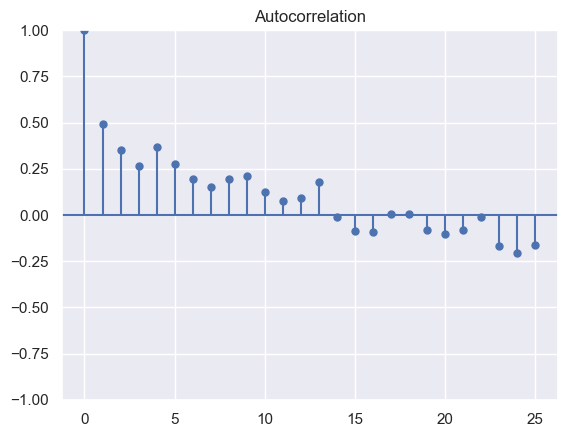

In [83]:
import pmdarima as pm

pm.plot_acf(train_bc_sku["sales_bc"].values)

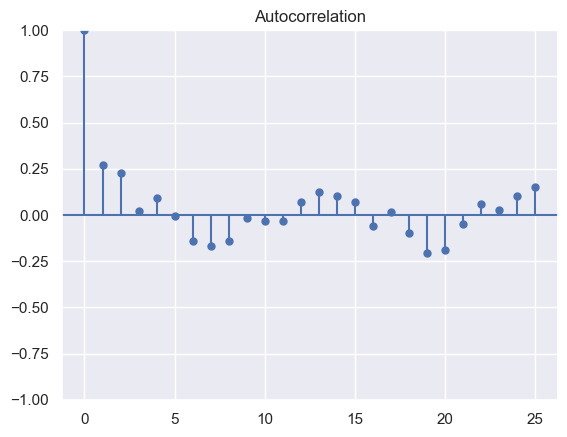

In [84]:
pm.plot_acf(train_bc_sku_other["sales_bc"].values)

In [86]:
from pmdarima import auto_arima

In [87]:
model_sku = auto_arima(
    train_bc_sku["sales_bc"].values,
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    m=52,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3968.733, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3832.353, Time=2.77 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3864.564, Time=1.81 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4632.816, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3887.104, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=27.76 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3828.594, Time=4.27 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3847.680, Time=1.73 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=28.66 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=3840.624, Time=16.69 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=3842.396, Time=11.41 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=29.68 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=3902.295, Time=2.33 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=3815.027, Time=5.15 sec
 ARIMA(2,0,0)(0,0,1)[52] inte

In [89]:
model_sku_other = auto_arima(
    train_bc_sku_other["sales_bc"].values,
    #exogenous=train[features],
    trace=True,
    error_action="ignore",
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    start_p=0, start_q=0, start_P=0, start_Q=0,
    max_p=5, max_q=5, max_P=5, max_Q=5,
    m=52,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2645.837, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2603.758, Time=2.99 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2613.284, Time=1.69 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3496.603, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2625.080, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2599.857, Time=22.62 sec
 ARIMA(1,0,0)(3,0,0)[52] intercept   : AIC=inf, Time=55.98 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=2604.515, Time=22.15 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2600.455, Time=4.06 sec
 ARIMA(1,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=75.11 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=19.04 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=2594.263, Time=28.71 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2598.435, Time=3.47 sec
 ARIMA(2,0,0)(3,0,0)[52] intercept   : AIC=inf, Time=65.90 sec
 ARIMA(2,0,0)(2,0,1)[52] interce

In [95]:
order = (2, 0, 0)
seasonal_order = (1, 0, 1, 52)

In [93]:
from scipy.special import inv_boxcox
from pmdarima import ARIMA

In [143]:
mod = ARIMA(order=order, seasonal_order=seasonal_order, with_intercept=True)
mod.fit(train_bc_sku["sales_bc"].values)
predict_sku = inv_boxcox(mod.predict(n_periods=8), l) + (train_bc_sku["sales"].min() if train_bc_sku["sales"].min() < 0 else 0)

mod_other = ARIMA(order=order, seasonal_order=seasonal_order, with_intercept=True)
mod_other.fit(train_bc_sku_other["sales_bc"].values)
predict_sku_other = inv_boxcox(mod_other.predict(n_periods=8), l_other) + (train_bc_sku_other["sales"].min() if train_bc_sku_other["sales"].min() < 0 else 0)

/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
prophet_predicts_daily = pd.read_parquet("../predicts/prophet_daily.parquet")
prophet_predicts_weekly = pd.read_parquet("../predicts/prophet_weekly.parquet")

In [128]:
prophet_predicts_daily_sku = prophet_predicts_daily[prophet_predicts_daily["sku"] == sku]
prophet_predicts_daily_sku_agg = prophet_predicts_daily_sku = prophet_predicts_daily_sku.set_index("date").groupby("sku").resample("W-SUN", label="left", closed="left")[["sales", "yhat"]].sum().reset_index()
prophet_predicts_weekly_sku = prophet_predicts_weekly[prophet_predicts_weekly["sku"] == sku]


prophet_predicts_daily_sku_o = prophet_predicts_daily[prophet_predicts_daily["sku"] == 151]
prophet_predicts_daily_sku_o_agg = prophet_predicts_daily_sku_o = prophet_predicts_daily_sku_o.set_index("date").groupby("sku").resample("W-SUN", label="left", closed="left")[["sales", "yhat"]].sum().reset_index()
prophet_predicts_weekly_sku_o = prophet_predicts_weekly[prophet_predicts_weekly["sku"] == 151]

In [109]:
df_raw = pd.read_parquet("../data/sku_sales.parquet").sample(100000)

In [111]:
val_weeks[0], val_weeks[1]

(Timestamp('2025-07-22 00:00:00'), Timestamp('2025-05-27 00:00:00'))

In [112]:
df["date"].max()

Timestamp('2025-09-14 00:00:00')

In [113]:
test.shape[0]

0

In [114]:
val_weeks

[Timestamp('2025-07-22 00:00:00'),
 Timestamp('2025-05-27 00:00:00'),
 Timestamp('2025-04-01 00:00:00'),
 Timestamp('2025-02-04 00:00:00'),
 Timestamp('2024-12-10 00:00:00'),
 Timestamp('2024-10-15 00:00:00'),
 Timestamp('2024-08-20 00:00:00')]

In [115]:
test = df[df["date"] >= val_weeks[0]]
test_daily = df_raw[df_raw["date"] >= val_weeks[0]]

test_sku = test[test["sku"] == sku]
test_sku_other = test[test["sku"] == 151]
print(test_sku.shape[0])

8


In [120]:
prophet_predicts_daily_sku_agg.head()

,sku,date,sales,yhat
0,28,2024-08-18,154884.0,192503.769466
1,28,2024-08-25,350752.0,234036.272215
2,28,2024-09-01,128271.0,245282.367341
3,28,2024-09-08,230799.0,265060.797145
4,28,2024-09-15,223261.0,310339.727278


In [122]:
prophet_predicts_daily_sku_agg[prophet_predicts_daily_sku_agg["date"] >= val_weeks[0]].shape[0]

8

In [130]:
prophet_predicts_weekly_sku[prophet_predicts_weekly_sku["date"] >= val_weeks[0]].shape[0]

8

In [139]:
train_bc_sku.tail()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num,sales_bc,sales_positive
7460,28,2025-06-22,446773.0,337761.75,1351047.0,284351.375,2274811.0,240759.415094,12760249.0,303752.0,25,6,959.553672,446773.0
7461,28,2025-06-29,369250.0,383465.50,1533862.0,302064.500,2416516.0,239682.830189,12703190.0,426309.0,26,6,877.174546,369250.0
7462,28,2025-07-06,420675.0,428717.50,1714870.0,336860.625,2694885.0,242242.641509,12838860.0,285005.0,27,7,932.734445,420675.0
7463,28,2025-07-13,388142.0,406210.00,1624840.0,350868.250,2806946.0,243196.188679,12889398.0,337604.0,28,7,898.035517,388142.0
7464,28,2025-07-20,537057.0,428781.00,1715124.0,383271.375,3066171.0,249327.566038,13214361.0,212094.0,29,7,1046.431565,537057.0


In [140]:
test_sku.head()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num
7465,28,2025-07-27,139054.0,371232.00,1484928.0,377348.750,3018790.0,246535.924528,13066404.0,287011.0,30,7
7466,28,2025-08-03,230484.0,323684.25,1294737.0,376200.875,3009607.0,246949.754717,13088337.0,208551.0,31,8
7467,28,2025-08-10,97127.0,250930.50,1003722.0,328570.250,2628562.0,241670.150943,12808518.0,376946.0,32,8
7468,28,2025-08-17,239615.0,176570.00,706280.0,302675.500,2421404.0,240987.283019,12772326.0,275807.0,33,8
7469,28,2025-08-24,353230.0,230114.00,920456.0,300673.000,2405384.0,243981.415094,12931015.0,194541.0,34,8


In [141]:
df_raw[df_raw["sku"] == sku][df_raw["date"].between("2025-07-13", "2025-08-03")].sort_values("date")

/var/folders/tp/hmzw0d5x7hl8p8p05gp81zwh0000gn/T/ipykernel_16461/3914531437.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_raw[df_raw["sku"] == sku][df_raw["date"].between("2025-07-13", "2025-08-03")].sort_values("date")


,sku,date,sales
10015,28,2025-07-22,61867.0
10016,28,2025-07-23,80071.0
10017,28,2025-07-24,50857.0
10020,28,2025-07-29,27319.0
10022,28,2025-07-31,41683.0


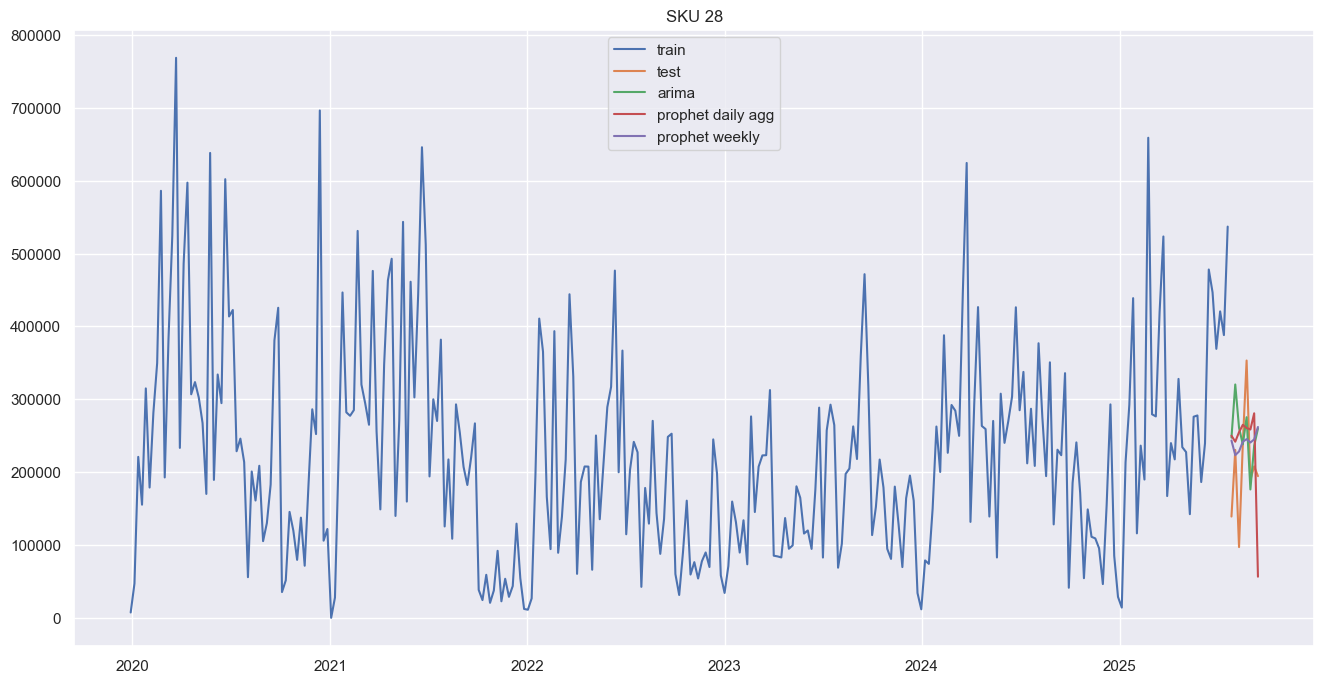

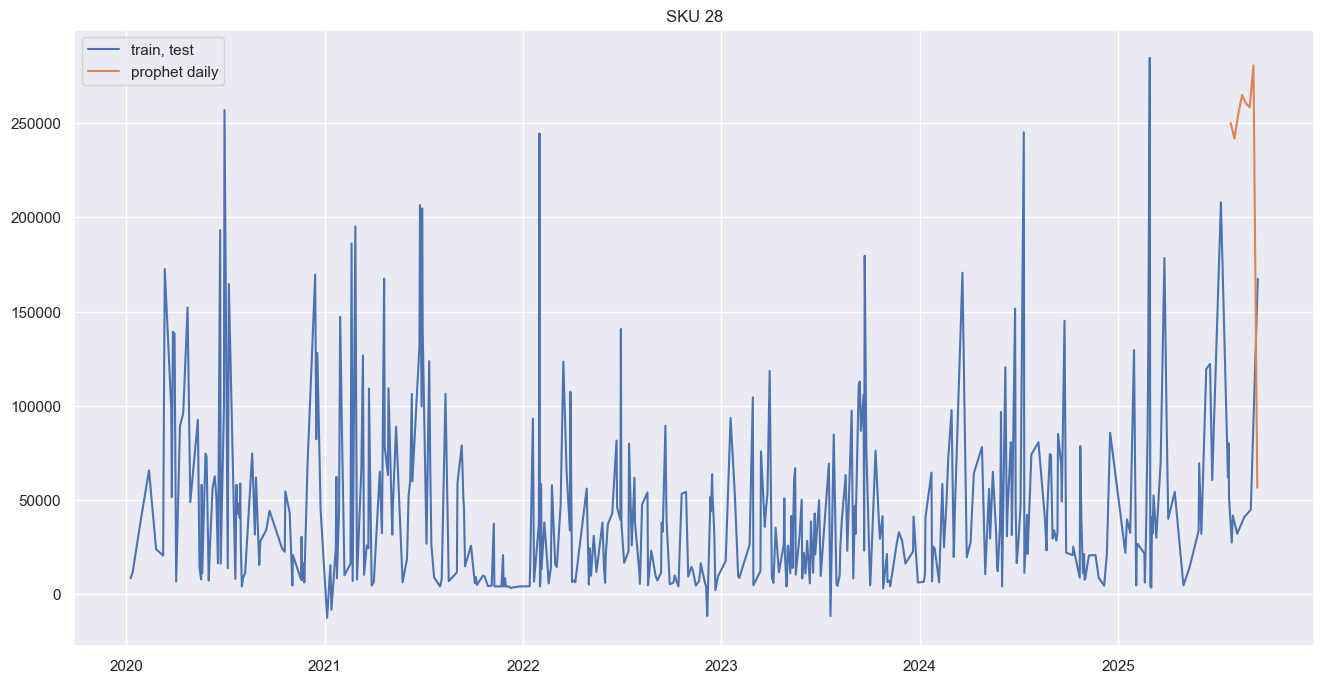

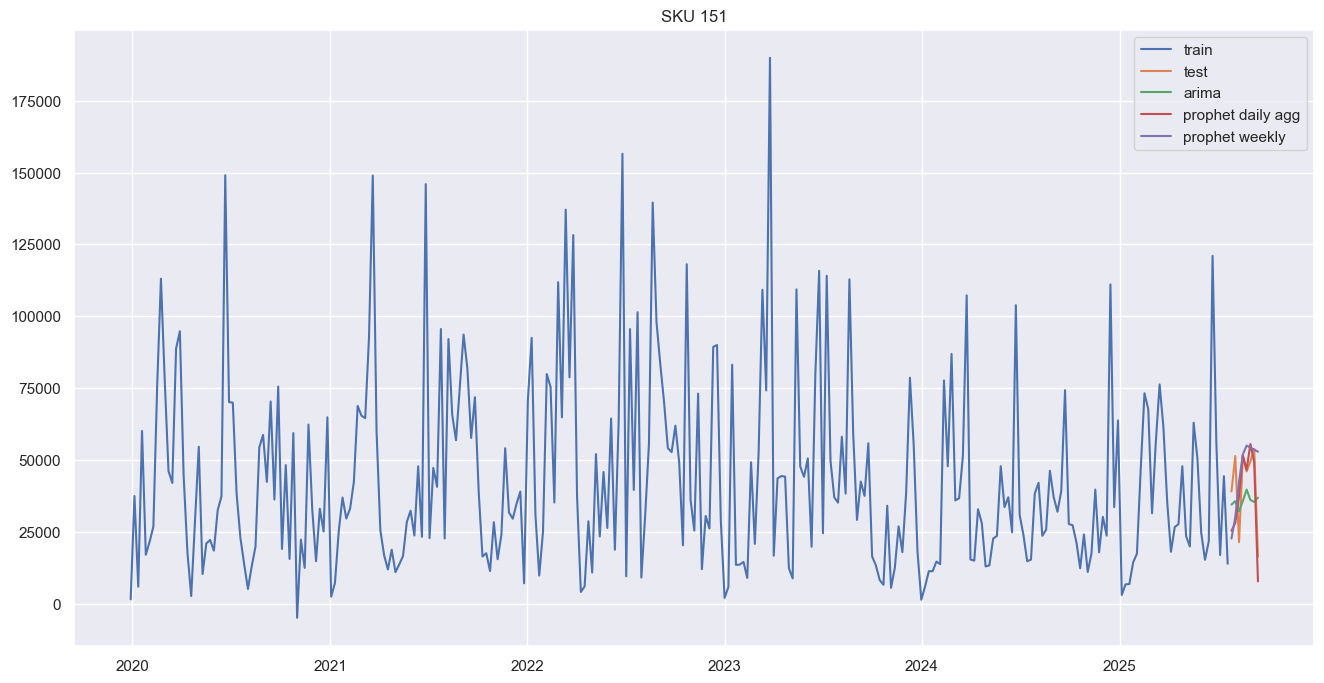

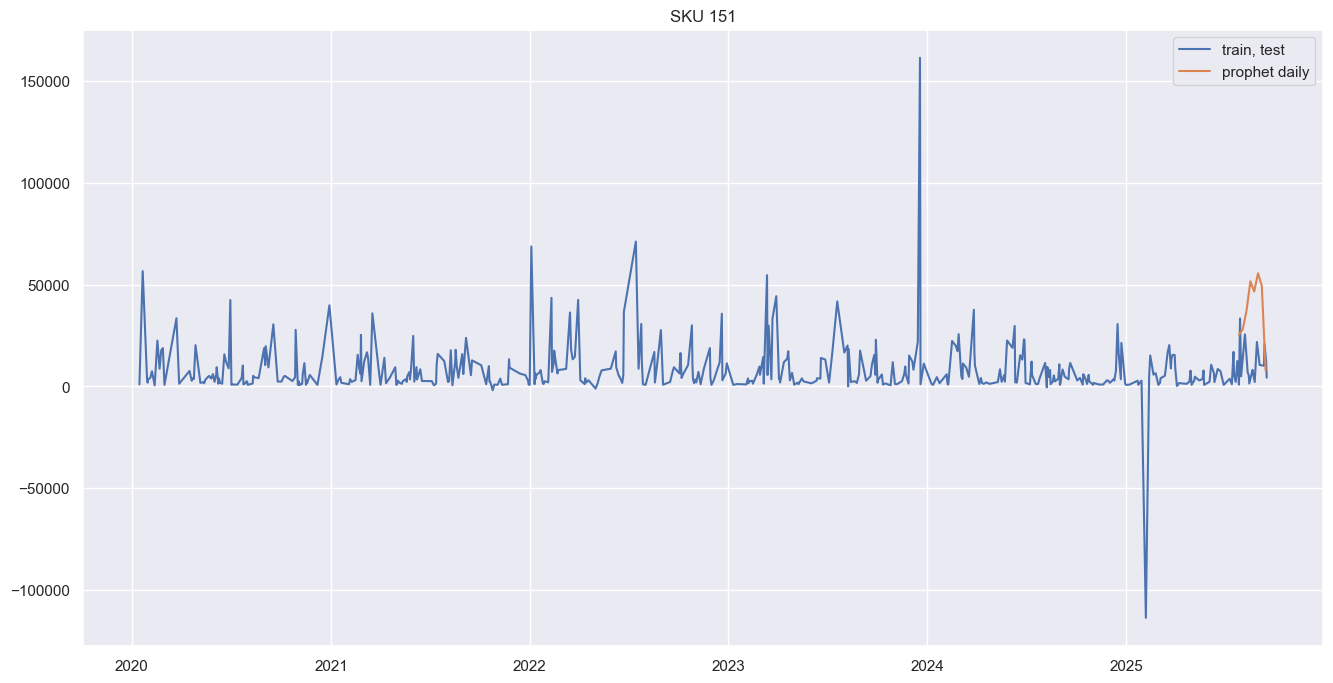

In [138]:
plt.figure(figsize=(16, 8))
plt.plot(train_bc_sku["date"].values, train_bc_sku["sales"].values, label="train")
plt.plot(test_sku["date"].values, test_sku["sales"].values, label="test")

plt.plot(test_sku["date"].values, predict_sku, label="arima")
plt.plot(test_sku["date"].values, prophet_predicts_daily_sku_agg[prophet_predicts_daily_sku_agg["date"] >= val_weeks[0]]["yhat"].values, label="prophet daily agg")
plt.plot(test_sku["date"].values, prophet_predicts_weekly_sku[prophet_predicts_weekly_sku["date"] >= val_weeks[0]]["predict"].values, label="prophet weekly")

plt.legend()
plt.title(f"SKU {sku}")
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(df_raw[df_raw["sku"] == sku].sort_values("date")["date"].values, df_raw[df_raw["sku"] == sku].sort_values("date")["sales"].values, label="train, test")
plt.plot(test_sku["date"].values, prophet_predicts_daily_sku[prophet_predicts_daily_sku["date"] >= val_weeks[0]]["yhat"].values, label="prophet daily")
plt.legend()
plt.title(f"SKU {sku}")
plt.show()


plt.figure(figsize=(16, 8))
plt.plot(train_bc_sku_other["date"].values, train_bc_sku_other["sales"].values, label="train")
plt.plot(test_sku_other["date"].values, test_sku_other["sales"].values, label="test")

plt.plot(test_sku_other["date"].values, predict_sku_other, label="arima")
plt.plot(test_sku_other["date"].values, prophet_predicts_daily_sku_o_agg[prophet_predicts_daily_sku_o_agg["date"] >= val_weeks[0]]["yhat"].values, label="prophet daily agg")
plt.plot(test_sku_other["date"].values, prophet_predicts_weekly_sku_o[prophet_predicts_weekly_sku_o["date"] >= val_weeks[0]]["predict"].values, label="prophet weekly")

plt.legend()
plt.title(f"SKU {151}")
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(df_raw[df_raw["sku"] == 151].sort_values("date")["date"].values, df_raw[df_raw["sku"] == 151].sort_values("date")["sales"].values, label="train, test")
plt.plot(test_sku_other["date"].values, prophet_predicts_daily_sku_o[prophet_predicts_daily_sku_o["date"] >= val_weeks[0]]["yhat"].values, label="prophet daily")
plt.legend()
plt.title(f"SKU {151}")
plt.show()

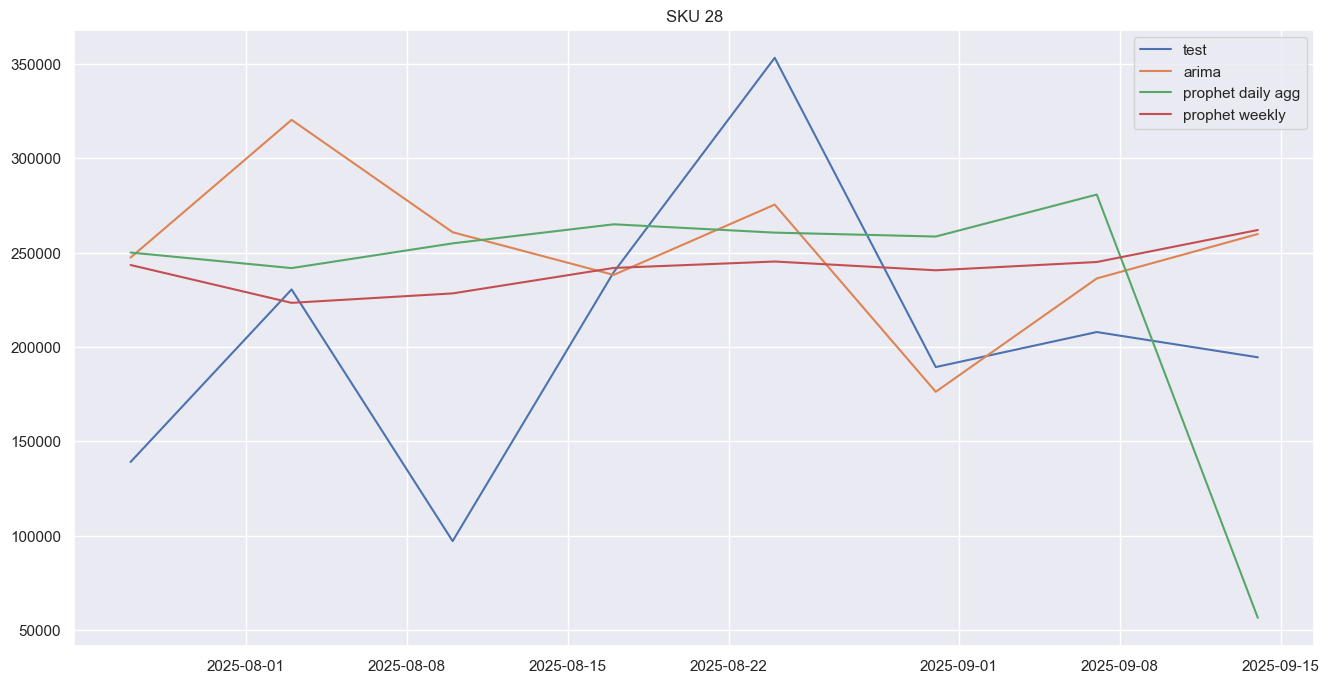

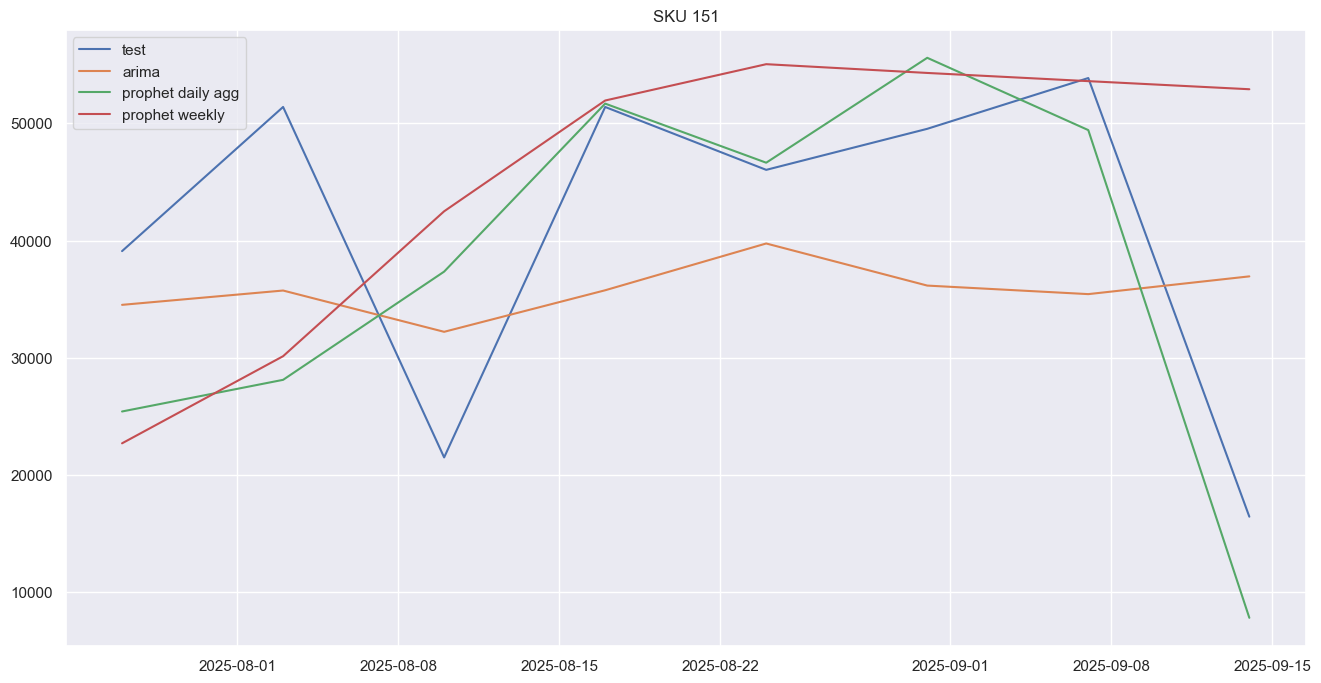

In [144]:
plt.figure(figsize=(16, 8))
#plt.plot(train_bc_sku["date"].values, train_bc_sku["sales"].values, label="train")
plt.plot(test_sku["date"].values, test_sku["sales"].values, label="test")

plt.plot(test_sku["date"].values, predict_sku, label="arima")
plt.plot(test_sku["date"].values, prophet_predicts_daily_sku_agg[prophet_predicts_daily_sku_agg["date"] >= val_weeks[0]]["yhat"].values, label="prophet daily agg")
plt.plot(test_sku["date"].values, prophet_predicts_weekly_sku[prophet_predicts_weekly_sku["date"] >= val_weeks[0]]["predict"].values, label="prophet weekly")

plt.legend()
plt.title(f"SKU {sku}")
plt.show()



plt.figure(figsize=(16, 8))
#plt.plot(train_bc_sku_other["date"].values, train_bc_sku_other["sales"].values, label="train")
plt.plot(test_sku_other["date"].values, test_sku_other["sales"].values, label="test")

plt.plot(test_sku_other["date"].values, predict_sku_other, label="arima")
plt.plot(test_sku_other["date"].values, prophet_predicts_daily_sku_o_agg[prophet_predicts_daily_sku_o_agg["date"] >= val_weeks[0]]["yhat"].values, label="prophet daily agg")
plt.plot(test_sku_other["date"].values, prophet_predicts_weekly_sku_o[prophet_predicts_weekly_sku_o["date"] >= val_weeks[0]]["predict"].values, label="prophet weekly")

plt.legend()
plt.title(f"SKU {151}")
plt.show()

#### get box cox lambda and arima forecast for one set of params

In [23]:
import logging
from scipy.special import inv_boxcox
from pmdarima import ARIMA

logging.getLogger("pmdarima").setLevel(logging.ERROR)
logging.getLogger("scipy").setLevel(logging.ERROR)
logging.getLogger("statmodels").setLevel(logging.ERROR)

from config import get_frequency_params
from model import clip_forecast
from typing import List
import os
from config import Config

In [ ]:
from scipy.stats import boxcox

In [24]:
order = (2, 0, 0)
seasonal_order = (1, 0, 1, 52)

config = Config(frequency="week", predict_folder="../predict", model_name="arima", data_folder="../data", horizon_days=7*8, heuristics_min_rows=10)

In [25]:
ci_levels = [config.ci_levels[-1]]
horizon_period, freq_mult, freq_name = get_frequency_params(config.frequency, config.horizon_days)

sku_not_predicted = set()

forecast_all: List[pd.DataFrame] = []
for sku, df_sku in train.groupby("sku"):
    print(sku)
    
    if df_sku.shape[0] < config.heuristics_min_rows or df_sku["sales"].std() < 1e-5 or df_sku["sales"].max() < 1e-5:
        print("const mean")
        
        const_forecast = max(df_sku["sales"].mean(), 0)

        # compute confidence intervals from residuals for leave-one-out strategy
        residuals = []
        for ind, row in df_sku.iterrows():
            loo_forecast = df_sku[df_sku.index.values != ind]["sales"].mean()
            loo_residual = row["sales"] - loo_forecast

            residuals.append(loo_residual)

        ci_lengths = np.percentile(residuals, [x * 100 for x in ci_levels])
        level_ci_length = dict(zip(ci_levels, ci_lengths))

        test_start_date = df_sku["date"].iloc[-1]
        forecast = pd.DataFrame(
            {
                "date": [test_start_date + pd.Timedelta(days=i * freq_mult) for i in range(1, horizon_period + 1)],
                "predict": [const_forecast] * horizon_period,
            }
        )

        for level in ci_levels:
            forecast[f"lower_{level}"] = forecast["predict"] - level_ci_length[level]
            forecast[f"upper_{level}"] = forecast["predict"] + level_ci_length[level]

        forecast["model_type"] = "const_mean"
    else:
        
        # prepare: shift to positive, apply Box-Cox with optimized lamda 
        min_sales = df_sku["sales"].min()
        if min_sales < 1e-5:
            df_sku["sales_positive"] = df_sku["sales"].apply(lambda x: x + 1 if x > 0 else 1) #x - min_sales + 1)
        else:
            df_sku["sales_positive"] = df_sku["sales"]

        sales_bc, lmbda = boxcox(df_sku["sales_positive"].values)

        # fit, predict
        try:
            mod = ARIMA(order=order, seasonal_order=seasonal_order, with_intercept=True)
            mod.fit(sales_bc)
            forecast_raw = inv_boxcox(mod.predict(n_periods=horizon_period), lmbda) + (-1 if min_sales < 0 else 0) #(min_sales - 1 if min_sales < 0 else 0)

            forecast = pd.DataFrame({"predict": forecast_raw, "date": [test_start_date + pd.Timedelta(days=i * freq_mult) for i in range(1, horizon_period + 1)],})
            forecast["model_type"] = "ARIMA"
            

            print("arima")
        except:
            sku_not_predicted.add(sku)
            print("error")
            
        

        #forecast: pd.DataFrame = None  # type: ignore
        #for level in ci_levels:
        #    forecast_level, ci = model.predict(n_periods=test.shape[0], return_conf_int=True, alpha=1 - level)
        #    forecast_level = forecast_level[forecast_level["date"] > train["date"].max()]
        #    forecast_level = forecast_level.rename(
        #        columns={"ds": "date", "yhat": "predict", "yhat_lower": f"lower_{level}", "yhat_upper": f"upper_{level}"}
        #    )
        #
        #    if forecast is None:
        #        forecast = forecast_level
        #    else:
        #        forecast = forecast.merge(forecast_level[["date", f"lower_{level}", f"upper_{level}"]], on="date")

        #forecast = pd.DataFrame({"predict": forecast_raw})
        #forecast["model_type"] = "ARIMA"


    
    if sku not in sku_not_predicted:
        forecast["sku"] = sku
        forecast_all.append(forecast)

forecast_all_pd = pd.concat(forecast_all)
#forecast_all_pd = clip_forecast(forecast_all_pd, list(config.ci_levels))

result = test.copy()
result = test.merge(
        forecast_all_pd,
        on=["date", "sku"],
        how="left",
)

0
arima
1


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2
arima
3


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
4


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
5
arima
6
arima
7


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
8
arima
9
arima
10


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
11


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
12
arima
13
arima
14
arima
15
arima
16
arima
17
arima
18


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
19


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
20
arima
21
arima
22


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
23
arima
24


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
25


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
26


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
27
arima
28


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
29
arima
30
arima
31
arima
32
arima
33
arima
34
arima
35
arima
36
const mean
37
arima
38


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
39


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
40
arima
41
const mean
42
arima
43
arima
44


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
45


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
46
arima
47


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
48


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
49


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
50


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
51


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
52


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
53
arima
54


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
55


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
56
arima
57


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
58


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
60


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
61
arima
62
const mean
63
const mean
64
const mean
65
arima
66
const mean
67
arima
68
arima
69
arima
70
arima
71


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
72


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
73
arima
74


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
75
arima
76


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
77


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
78
arima
79


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
80


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
81
arima
82
arima
83


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
84


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
85
arima
86
arima
87
arima
88
arima
89


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
90
arima
91


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
92
arima
93
arima
94
arima
95
arima
96


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
97


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
98
arima
99


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
100


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
101


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
102
arima
103
arima
104
const mean
105
arima
106


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
107
arima
108


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
109


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
110


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
111
arima
112


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
113


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
114


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
115
arima
116


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
117
const mean
118


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
119


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
120
arima
121


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
122
arima
123


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
124


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
125
arima
126
arima
127
arima
128


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
129


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
130


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
131


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
132


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
133
const mean
134
arima
136
arima
137


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
138


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
139
arima
140
arima
141


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
142
arima
143
const mean
144


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
145
arima
146
const mean
147


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
148


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
149


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
150
arima
151


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
152


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
153
arima
154
const mean
155


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
156
const mean
157
const mean
158
arima
159
arima
160
arima
161
arima
162
arima
163


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_fo

arima
164
arima
165


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
166
arima
167
arima
168
arima
169
arima
170
arima
171


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
172
arima
173
arima
174


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
175
arima
176


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
177
arima
178


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
179


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
180


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
181
arima
182


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
183


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
184


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
185


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
186
arima
187
arima
188
arima
189
arima
190
arima
191
arima
192


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
193
arima
194
arima
195
arima
196
const mean
197


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
198


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
199
arima
200
arima
201


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
202
arima
205


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
206
arima
207
arima
208
arima
209


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
210


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
211
arima
212


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
213
arima
214


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
215
const mean
216
arima
217


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
218
arima
219


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
220


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
221
arima
222


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
223


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
224
arima
225
arima
226


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
227
arima
228


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
229


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
230
arima
231


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
232
arima
233


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
234
arima
235


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
236
const mean
237
const mean
238
arima
239
const mean
241
arima
242


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
243


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
244


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
245
arima
246


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
247


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
248


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
249


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
250
arima
251
arima
252
arima
253
arima
254
arima
255
arima
256


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
257


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
258


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
259


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
260


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
261
arima
262


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
263


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
264
arima
265


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
266


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
267


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
268


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
269


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
270
arima
271
arima
272
const mean
273
arima
274


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
275
arima
276


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
277
arima
278


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
279
arima
280
arima
281


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
282
arima
283


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
284


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
285


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
286


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
287


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
288
arima
289


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
290


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
291
arima
292
arima
293


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
294
arima
295
arima
296


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
297
arima
298
arima
299


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
300


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
301


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
302
arima
303
arima
304
arima
305


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
306


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
307
arima
308
arima
309
arima
310
arima
311
arima
312
arima
313
arima
314
arima
315


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
316
arima
317
arima
318


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
319
arima
320


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
321
arima
322
arima
323
arima
324


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
325


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
326
arima
327


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
328


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
329


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
330
arima
332


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
333


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
334


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
335


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
336
arima
337
arima
338
arima
339
arima
340
arima
341
arima
342


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
343
arima
344
arima
345
arima
346
arima
347
arima
348
arima
349
arima
350


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
351
arima
352


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
353
arima
354


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
355


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
356


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
357
arima
358


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
359


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
360
arima
361


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
362


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
363


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
364
arima
365
arima
366
arima
367
arima
368


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
369
arima
370


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
371
arima
372
arima
373
arima
374


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
375
arima
376


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
377


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
378


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
379
arima
380
arima
381


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
382
arima
383


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
384
arima
385


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
386
arima
387
arima
388
arima
389


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
390
arima
391
arima
392


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
393


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
394


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
395
arima
396
arima
397
arima
398
arima
399
arima
400
arima
401


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
402


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
403
arima
404
arima
405
arima
406


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
407


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
408


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
409
arima
410


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
411


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
412


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
413
arima
414
arima
415


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
416


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
417
arima
418


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
419
arima
420
arima
421
arima
422
arima
423
arima
424
arima
425
arima
426


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
427


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
428


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
429
arima
430
arima
431
arima
432
arima
433


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
434


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
435
arima
436
arima
437


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
438
arima
439


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
440


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
441
arima
442
arima
443
arima
444


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
445


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
446
arima
447
arima
448


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
449


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
450


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
451


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
452
arima
453
arima
454
arima
455
arima
456
arima
457
arima
458
arima
459
arima
460
arima
461


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
462


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
463


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
464
arima
465
arima
466


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
467
arima
468


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
469
arima
470
arima
471
arima
472
const mean
473
arima
474
arima
475
arima
476


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
477


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
478
arima
479
arima
480
arima
481


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
482


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
483
arima
484
arima
485
arima
486


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
487
arima
488
arima
489
arima
490


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
491
arima
492
arima
493


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
494


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
495
arima
496


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
497
arima
498
arima
499
arima
500
arima
501


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
502


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
503


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
504
arima
505


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
506


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
507
arima
508


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
509
arima
510
arima
511


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
512


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
513
arima
514


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
515
arima
516
arima
517
arima
518


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
519
arima
520


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
521
arima
522


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
523


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
524
arima
525
arima
526


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
527


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
528


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
529


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
530
arima
531
arima
532


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
533


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
534


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
535


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
536
arima
537
arima
538


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
539


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
540


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
541
arima
542
arima
543
arima
544
arima
545


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
546


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
547
arima
548


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
550
arima
551
arima
552


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
553
arima
554
arima
555
arima
556
arima
557


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
558


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
559


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
560
arima
561
arima
562


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
563


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
564
arima
565
arima
566
arima
567
arima
568
arima
569
arima
570


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
571


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
572
arima
573
const mean
574
arima
575
arima
576


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
577


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
578


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
579
arima
580
arima
581


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
582
arima
583


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
584
arima
585


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
586
arima
587


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
588
arima
589


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
590
arima
591
arima
592


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
593


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
594


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
595
arima
596


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
597


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
598
arima
599


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
600
arima
601


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
602
arima
603
arima
604
arima
605
arima
606
arima
607
arima
608
arima
609
arima
610
arima
611
arima
612
arima
613
arima
614
arima
615


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
616


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
617
arima
618
arima
619
arima
620
arima
621
arima
622


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
623
arima
624
arima
625
arima
626
arima
627
arima
628
arima
629
arima
630


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
631
arima
632
arima
633
arima
634


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
635


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
636


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
637


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
638


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
639


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
640


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
641
arima
642


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
643
arima
644
arima
645


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
646
arima
647


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
648
arima
649
arima
650
arima
651
arima
652
arima
653
arima
654


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
655
arima
656
arima
657
arima
658


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
659


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
660


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
661


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
662
arima
663
arima
664
arima
665
arima
666


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
667
arima
668


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
669
arima
670
arima
671


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
672


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
673
arima
674
arima
675
arima
676
arima
677


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
678
arima
680


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
681


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
682
arima
683
arima
684
arima
685
arima
686


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
687
arima
688


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
689
arima
690
arima
691
arima
692
arima
693
arima
694
arima
695


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
696
arima
697


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
698
arima
699
arima
700


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
701


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
702
arima
703


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
704
arima
705


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
707
arima
708


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
709
arima
710
arima
711
arima
712
arima
713
arima
714
arima
715


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
716
arima
717
arima
718
arima
719


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
720


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
721
arima
722
arima
723
arima
724
arima
725
arima
726


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
727


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
728
arima
729
arima
730
arima
731
arima
732
arima
733
arima
734
arima
735
arima
736
arima
737


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
738
arima
739
arima
740


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
741
arima
742


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
743


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
744


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
745


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
746


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
747
arima
748
arima
749


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
750


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
751
arima
753
arima
754


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
755
arima
756
arima
757
arima
758
arima
759
arima
760
arima
761


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
762
arima
763
arima
764


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
765
arima
766
arima
767
arima
768
arima
769
arima
770
arima
771


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
772
arima
773


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
774
arima
775


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
776


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
777
arima
778


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
779


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
780
arima
781
const mean
782
arima
783
arima
784


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
785


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
786
arima
787


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
788
arima
789
arima
790
arima
791
arima
792
arima
793
arima
794
arima
795
arima
796
arima
797
arima
798


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
799
arima
800
arima
801


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
802
const mean
803


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
804
arima
805
arima
806
arima
807
arima
808
arima
809
arima
810
arima
811
arima
812
arima
813
arima
814
arima
815
arima
816
arima
817


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
818


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
819
arima
820
arima
821
arima
822
arima
823
arima
824


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
825
arima
826
arima
827
arima
828
arima
829


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
830
arima
831


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
832


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
833
arima
834
arima
835


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
836


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
837
arima
838


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
839


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
840
arima
841


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
842
arima
843
arima
844
arima
845


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
846


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
847
arima
848


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
849


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
850
arima
851


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
852
arima
853
arima
854


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
855


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
856
arima
857
arima
858
arima
859
arima
860
arima
861
arima
862
arima
863
arima
864
arima
865


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
866
arima
867


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
868
arima
869
arima
870
arima
871
arima
872
arima
873
arima
874
arima
875
arima
876


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
877
arima
878
arima
879
arima
880
arima
881
arima
882
arima
883
arima
884
arima
885


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
886
arima
887


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
888


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
889
arima
890
arima
891
arima
892
arima
893
arima
894
arima
895
arima
896


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
897
arima
898
arima
899
arima
900


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
901
arima
902
arima
903
arima
904
arima
905
arima
906
arima
907
arima
908
arima
909
arima
910
arima
911
arima
912
arima
913
arima
914
arima
916


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
917


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
918
arima
919


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
920
arima
921
arima
922
arima
923


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
924


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
925
arima
926
arima
927
const mean
928
const mean
929


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
930
arima
931
arima
932
arima
933
arima
934


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
935
arima
936
arima
937
arima
938


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
939
arima
940
arima
941


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
942
arima
943
arima
944
arima
945
const mean
946
arima
947


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
948
arima
949


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
950
arima
951


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
952


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
953


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
954
arima
955
arima
956
arima
957
arima
958
arima
959
arima
960
arima
961


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
962
arima
963
arima
964


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
965
arima
966
arima
967
arima
968


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
969
arima
970
arima
971


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
972
arima
973
arima
974


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
975
arima
976


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
977


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
978
arima
979
arima
980


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
981
arima
982
arima
983
arima
984
arima
985
arima
986
arima
987


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
988
arima
989


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
990


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
991


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
992
arima
993


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
994


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
995
arima
996


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
997
arima
998
arima
999
arima
1000
arima
1001
arima
1002
arima
1003
arima
1004
arima
1005
arima
1006
arima
1007
arima
1008
arima
1009
arima
1010
arima
1011


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1012
arima
1013
arima
1014
arima
1015


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1017
arima
1018
arima
1019
arima
1020
arima
1021
arima
1022
arima
1023
arima
1024
arima
1025
arima
1026


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1027


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1028
arima
1029
arima
1030


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1031
arima
1032


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1033
arima
1034
arima
1035
arima
1036
arima
1037
arima
1038
arima
1039


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1040
arima
1041
arima
1042
arima
1043
arima
1044
const mean
1045
arima
1046
arima
1047
arima
1048
arima
1049
arima
1050
arima
1051


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1052
arima
1053
arima
1054
arima
1055
arima
1056
arima
1057
arima
1058
arima
1059


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1060
arima
1061
arima
1062
arima
1063
arima
1064


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1065


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1066
arima
1067
arima
1068


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1069
arima
1070
arima
1071
arima
1072
arima
1073
arima
1074
arima
1075
arima
1076
arima
1077


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1078
arima
1079
arima
1080
arima
1081


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1082
arima
1083


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1084


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1085
arima
1086


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1087
arima
1088
arima
1089
arima
1090


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1091
arima
1092
arima
1093
arima
1094
arima
1095


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1096


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1097
arima
1098
arima
1099
arima
1100
arima
1101
arima
1102
arima
1103
arima
1104
arima
1105
arima
1106
arima
1107


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1108


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1109
arima
1110


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1111
arima
1112


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1113
arima
1114
arima
1115
arima
1116


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1117
arima
1118


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1119
arima
1120
arima
1121
arima
1122
arima
1123
arima
1124
arima
1125
arima
1126
arima
1127


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1128
arima
1129
arima
1130
arima
1131
arima
1132
arima
1133
arima
1134
arima
1135
arima
1136
arima
1137
arima
1138
arima
1139
arima
1140


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1141
arima
1142
arima
1143
arima
1144
arima
1145
arima
1146
arima
1147
arima
1148


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1149
arima
1150
arima
1151


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1152
arima
1153
arima
1154
arima
1155
arima
1156
arima
1157
arima
1158
arima
1159
arima
1160
arima
1161


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1162
arima
1163
arima
1164
arima
1165


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1166
arima
1167
arima
1168
arima
1169
arima
1170
arima
1171


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1172


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1173
arima
1174


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1175
arima
1176


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1177
arima
1178
arima
1179
arima
1180
arima
1181


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1182
arima
1183
arima
1184
arima
1185


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1186
arima
1187
arima
1188
arima
1189
arima
1190
arima
1191
arima
1192


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1193


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1194
arima
1195
arima
1196
arima
1197


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1198


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1199
arima
1200
arima
1201
arima
1202
arima
1203
arima
1204
arima
1205
arima
1206
arima
1207
arima
1208
arima
1209
arima
1210
arima
1211
arima
1212
arima
1213
arima
1214


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1215
arima
1216
arima
1217
arima
1218
arima
1219
arima
1220
arima
1221
arima
1222
arima
1223
arima
1224
arima
1225
arima
1226
arima
1227
arima
1228
arima
1229
arima
1230
arima
1231
arima
1232
arima
1233


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1234
arima
1235


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1236
arima
1237
arima
1238
arima
1239
arima
1240
arima
1241
arima
1242
arima
1243
arima
1244
arima
1245
arima
1246
arima
1247
arima
1248
arima
1249
arima
1250
arima
1251
arima
1252
arima
1253
arima
1254
arima
1255


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1256
arima
1257
arima
1258
arima
1259
arima
1260
arima
1261
arima
1262
arima
1263
arima
1264


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1265
arima
1266
arima
1267
arima
1268
arima
1269


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1270
arima
1271
arima
1272
arima
1273
arima
1274
arima
1275
arima
1276
arima
1277


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1278
arima
1279
arima
1280
arima
1281


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1282


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1283
arima
1284
arima
1285
arima
1286
arima
1287
arima
1288
arima
1289
arima
1290


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1291
arima
1292
arima
1293
arima
1294
arima
1295
arima
1296
arima
1297
arima
1298
arima
1299
arima
1300
arima
1301
arima
1302
arima
1303
arima
1304


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1305
arima
1306
arima
1307
arima
1308
arima
1309
arima
1310
arima
1311


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1312
arima
1313
arima
1314
arima
1315
arima
1316


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1317
arima
1318
arima
1319
arima
1320
arima
1321
arima
1322
arima
1323
arima
1324
arima
1325
arima
1326
arima
1327
arima
1328


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1329
arima
1330
arima
1331
arima
1332
arima
1333
arima
1334
arima
1335
arima
1336
arima
1337
arima
1338
arima
1339
arima
1340


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1341
arima
1342
arima
1343
arima
1344


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1345
arima
1346
arima
1347
arima
1348
arima
1349
arima
1350
arima
1351
arima
1352


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1353
arima
1354
arima
1355


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1356
arima
1357
arima
1358
arima
1359


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1360
arima
1361
arima
1362
arima
1363


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1364
arima
1365
arima
1366


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1367


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1368
arima
1369


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1370
arima
1371
arima
1372
arima
1373
arima
1374


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1375
arima
1376
arima
1377
arima
1378
arima
1379
arima
1380
arima
1381
arima
1382
arima
1383


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1384


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1385
arima
1386


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1387
arima
1388
arima
1389
arima
1390
arima
1391


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1392


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1393


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1394
arima
1395
arima
1396
arima
1397
arima
1398
arima
1399
arima
1400


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1401
arima
1402
arima
1403


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1404
arima
1405
arima
1406
arima
1407
arima
1408
arima
1409
arima
1410
arima
1411
arima
1412
arima
1413
arima
1414
arima
1415
arima
1416
arima
1417
arima
1418
arima
1419
arima
1420
arima
1421


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1422
arima
1423
arima
1424
arima
1425


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1426


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1427


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1428
arima
1429
arima
1430
arima
1431
arima
1432
arima
1433


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1434
arima
1435


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1436
arima
1437


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1438
arima
1439


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1440
arima
1441
arima
1442
arima
1443
arima
1444
arima
1445
arima
1446
arima
1447
arima
1448


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1449
arima
1450


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1451
arima
1452
arima
1453


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1454
arima
1455


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1456
arima
1457


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1458
arima
1459


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1460
arima
1461
arima
1462


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1463


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1464
arima
1465
arima
1466
arima
1467


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1468


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1469


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1470


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1471
arima
1472
arima
1473


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1474
arima
1475
arima
1476


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1477
arima
1478
arima
1479
arima
1480
arima
1481
arima
1482
arima
1483
arima
1484


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1485
arima
1486


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1487
arima
1488
arima
1489
arima
1490


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1491
arima
1492
arima
1493
arima
1494
arima
1495
arima
1496


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1497
arima
1498


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1499


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1500
arima
1501


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1502


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1503
arima
1504


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1505
arima
1506
arima
1507


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1508


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1509
arima
1510
arima
1511
arima
1512
arima
1513


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1514
arima
1515


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1516


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1517


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1518
arima
1519
arima
1520


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1521
arima
1522
arima
1523
arima
1524
arima
1525
arima
1526


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1527


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1528


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1529
arima
1530
arima
1531
arima
1532
arima
1533


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1534


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1535
arima
1536
arima
1537


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1538
arima
1539
arima
1540


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1541
arima
1542


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1543


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1544
arima
1545
arima
1546
arima
1547
arima
1548
arima
1549


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1550


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1551


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1552


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1553
arima
1554


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1555
arima
1556
arima
1557
arima
1558
arima
1559


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1560
arima
1561
arima
1562
arima
1563
arima
1564
arima
1565
arima
1566
arima
1567


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1568


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1569
arima
1570


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1571
arima
1572


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1573


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1574


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1575
arima
1576


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1577


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1578
arima
1579


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1580
arima
1581


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1582
arima
1583


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1584


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1585


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1586
const mean
1587


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1588


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1589


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1590


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1591


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1592
arima
1593


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1594


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1595


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1596


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1597
arima
1598


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
1599


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1600
arima
1601


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1602


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1603
arima
1604


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1605


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1606


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1607


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1608


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1609


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1610
const mean
1611


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1612


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1613


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1614


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1615


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1616
arima
1617


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1618
arima
1619


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1620


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1621


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1622
arima
1623


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1624
arima
1625


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1626


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1627
arima
1628


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1629


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1630


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1631


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1632


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1633


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1634


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1635


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1636


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1637


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1638


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1639
arima
1640


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1641


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1642


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1643
arima
1644
const mean
1645


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1646


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1647


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1648


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1649


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1650


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1651


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1652


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1653


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1654


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1655
const mean
1656


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1657


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1658


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1659


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1660


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1661


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1662
arima
1663
arima
1664
arima
1665


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1666
arima
1667


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1668


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1669
arima
1670
arima
1671


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1672
arima
1673
arima
1674


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1675
arima
1677
arima
1678
const mean
1679


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1680


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1681
arima
1682


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1683


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1684


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1685


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1686


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1687


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1688


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1689


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1690


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1691
arima
1692


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1693
arima
1694


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1695


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1696


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1697


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1698
const mean
1699
arima
1700


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1701


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1702
arima
1703


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1704
arima
1705
const mean
1706
arima
1707
arima
1708
const mean
1709


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1710
const mean
1712
arima
1713


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1714


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1715


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1716


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1717


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1718


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1719


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1720
const mean
1721


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1722


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1723


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1724


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1725


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1726


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1727
const mean
1728


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1729


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1730
const mean
1731


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1732
const mean
1733


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1734


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1735
const mean
1736
const mean
1737


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1738
const mean
1739
const mean
1740


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1741


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1742


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1743


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1744
arima
1745


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1747


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1748


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1749


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1750


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1751


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1752
const mean
1753


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1754


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1755


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1756


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1757
arima
1758


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1759


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1760


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1761


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1762


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1763


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1764
arima
1765


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1766


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1767


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1768
arima
1769


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
1770


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1771
arima
1772
arima
1773


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1774


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1775
arima
1776


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1777


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1778
arima
1779


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1780


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1781


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1782
arima
1783
arima
1784


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1785


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1786


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1787
arima
1788


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1789


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1790


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1791


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1792


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1793


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
1794


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1795
arima
1796
arima
1797


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1798


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1799


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1800


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1801


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1802


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1803


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1804
arima
1805
arima
1806


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1807


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1808


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1809


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1810
arima
1811
arima
1812


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1813


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1814


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1815


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1816


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1817
arima
1818
arima
1819
arima
1820
arima
1821


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1822
arima
1823


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1824
arima
1825


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1826
arima
1827


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1828
const mean
1829


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1830
arima
1831
arima
1832


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1833
arima
1834
arima
1835
arima
1836
arima
1837
arima
1838


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1839
arima
1840
arima
1841


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1842
arima
1843
arima
1844


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1845


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1846


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1847


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1848
arima
1849


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1850


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1852
arima
1853


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1854


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1855


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
1856
arima
1857


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1858


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1859


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1860


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1861


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1862


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1863
const mean
1864
const mean
1865
arima
1866
const mean
1867


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1868


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1869


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1872


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1873


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1874
arima
1875


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1876


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1877


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1878


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1879


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1880


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1881


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1882


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1883


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1884


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1885


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1886


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1887
arima
1888


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1889
arima
1890
arima
1891
const mean
1892
arima
1893
arima
1894
arima
1895
arima
1896
arima
1897
arima
1898
arima
1899
arima
1902


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1904
arima
1905


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1906


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1907
arima
1908


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1909


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1910
const mean
1911
arima
1912


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1913
arima
1914


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1915
const mean
1916


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1917


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1918


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1919
arima
1920
const mean
1921
const mean
1922
arima
1923
arima
1924
arima
1925
arima
1926
arima
1927


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1928
arima
1929
arima
1930
arima
1931
arima
1932
const mean
1933
arima
1934


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1935


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1936


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1937


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1938


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1939


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1940


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1941
arima
1942


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1943


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1944


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1945
const mean
1946


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1947


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1948


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1949
const mean
1950


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1951


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1952


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1953


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


arima
1954


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1955
const mean
1956
const mean
1957
const mean
1958
const mean
1959
const mean
1960
const mean
1961
const mean
1962
const mean
1963
const mean
1964
const mean
1965
const mean
1966
const mean
1967
const mean
1968
const mean
1969
const mean
1970
const mean
1971
const mean
1972
const mean
1973
const mean
1974
const mean
1975
const mean
1976
const mean
1977
const mean
1978
const mean
1979
const mean
1980
const mean
1981
const mean
1982


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
1983
const mean
1984
const mean
1985


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
1986
const mean
1987
const mean
1988
const mean
1989
const mean
1990
const mean
1991
const mean
1992
arima
1993
const mean
1994
const mean
1995
const mean
1996
const mean
1997
const mean
1998
const mean
1999
const mean
2000
const mean
2001
const mean
2002
const mean
2003
const mean
2004
const mean
2005
const mean
2006
const mean
2007
const mean
2008
const mean
2009
const mean
2010
const mean
2011
arima
2012
const mean
2013
const mean
2014
const mean
2015


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2016


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2017


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2018


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2019


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2020
arima
2021


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2022
const mean
2023
const mean
2024
const mean
2025
const mean
2026


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2027
const mean
2028
const mean
2029


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2030
const mean
2031
const mean
2032
const mean
2033
arima
2034


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2035


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2036
arima
2037


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2038


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2039


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2040


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2041


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2042


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2043


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2044


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2045


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2046
arima
2047
arima
2048


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2049
arima
2050
arima
2051


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2052


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2053


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2054


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2055


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2056


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2057


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2058


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2059


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2060


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2061


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2062


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2063


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2064


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2065


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2066


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2067
const mean
2068


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2069


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2070


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2071


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2072


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2073


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2074


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2075
arima
2076


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2077


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2078
arima
2079


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2080


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2081


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2082


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2083
arima
2084


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2085


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2086


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2087


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2088


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2089
arima
2090


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2091


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2092


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2093


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2094
arima
2095


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2096
arima
2097


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2098


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2099
const mean
2100
const mean
2101
arima
2102
arima
2103
arima
2104
arima
2105
arima
2106
arima
2107
arima
2108


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2109
arima
2110
arima
2111
arima
2112
arima
2113
arima
2114
arima
2115
arima
2116
arima
2118
arima
2119


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2120
arima
2121
arima
2122
arima
2124
arima
2125


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2126
arima
2127


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2128
arima
2129


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2130


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2131


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2132


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2133
arima
2134
arima
2135
arima
2136
arima
2137
arima
2138
arima
2139
arima
2140
arima
2141
arima
2142
arima
2143
arima
2144
arima
2145
arima
2146
arima
2147


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2148
arima
2149
arima
2150
arima
2151
arima
2152


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2153


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2154


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2155
arima
2156
arima
2157
arima
2158
arima
2159
arima
2160
arima
2161
arima
2162
arima
2163
const mean
2164
arima
2165
const mean
2166
arima
2167


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2168
arima
2169
arima
2170
arima
2171
arima
2172


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2173
arima
2174
arima
2175
arima
2176
arima
2177
arima
2178


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2179


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2180
arima
2181
arima
2182
arima
2183
arima
2184
arima
2185
arima
2186
arima
2187
arima
2188
arima
2189
arima
2190


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2191
arima
2192
arima
2193
arima
2194
arima
2195
arima
2196
arima
2197
arima
2198
arima
2199


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2200


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2201
arima
2202
arima
2203


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2204


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2205


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
2206


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2207


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2208
arima
2209
arima
2210


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2211
arima
2212
arima
2213
arima
2214
arima
2215
const mean
2216
arima
2217


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2218
arima
2219
arima
2220
arima
2221
arima
2222
arima
2223
arima
2224
arima
2225
arima
2226
arima
2227
arima
2228
arima
2229
arima
2230
arima
2231


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2232
arima
2233
arima
2234
arima
2235


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2236
arima
2237
arima
2238
arima
2239
arima
2240


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2241


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2242
arima
2243
arima
2244


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2245
arima
2246
arima
2247
arima
2248
arima
2249


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2250
arima
2251
arima
2252
arima
2253
arima
2254
arima
2255


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2256
arima
2257
arima
2258


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2259
arima
2260
arima
2261
arima
2262
arima
2263
arima
2264
arima
2265
arima
2266
arima
2267
arima
2268
arima
2269
arima
2270
arima
2271


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2272
arima
2273
const mean
2274
arima
2275


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2276
const mean
2277
arima
2278
arima
2279
arima
2280
arima
2281
arima
2282
arima
2283
arima
2284


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2285
arima
2286
arima
2287
arima
2288
arima
2289
arima
2290
arima
2291


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2292
arima
2293


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2294
arima
2295


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2296
arima
2297
arima
2298
arima
2299
arima
2300


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2301


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2302
arima
2303


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2304
arima
2305
arima
2306
arima
2307
arima
2308


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2309


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2310
arima
2311


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2312
arima
2313
arima
2314
arima
2315
arima
2316
arima
2317
arima
2318


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2319


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2320


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2321
arima
2322


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2323


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2324


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2325
arima
2326
arima
2327
arima
2328
arima
2329
arima
2330
arima
2331


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2332


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2333
arima
2334
arima
2335
arima
2336
arima
2337
arima
2338
arima
2339
arima
2340
arima
2341
arima
2342
arima
2343
arima
2344
arima
2345
arima
2346
arima
2347


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2348
arima
2349


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2350
arima
2351
arima
2352


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2353


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2354
arima
2355
arima
2356
arima
2357


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2358
arima
2359
arima
2360
arima
2361
arima
2362


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2363


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2364


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2365
arima
2366


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2367


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2368


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2369


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2370
arima
2371
arima
2372


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2373


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2374
arima
2375
arima
2376


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2377


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2378


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2379


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2380
const mean
2381


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2382


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2383
const mean
2384
arima
2385


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2386


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2387


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2388
arima
2389
const mean
2390


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2391
arima
2392
arima
2393
arima
2394
arima
2395
arima
2396
arima
2397


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2398


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2399


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2400
arima
2401


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2402


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2403


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2404


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2405


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2406


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2407
arima
2408
arima
2409


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2410


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2411


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2412
arima
2413
arima
2414
arima
2415


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2416
arima
2417
arima
2418


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
2419


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
2420


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2421
arima
2422
const mean
2423
arima
2424
arima
2425


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2426


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2427
arima
2428
arima
2429
arima
2430
arima
2431


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2432


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2433


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2434


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2435


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2436
arima
2437


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2438
arima
2439


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2440


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2441
arima
2442
arima
2443


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2444


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2445


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2446


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2447
arima
2448


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2449
arima
2450


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2451
arima
2452


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2453
arima
2454


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2455
arima
2456
arima
2457
arima
2458


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
2459
arima
2460


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2461
arima
2462
arima
2463
arima
2464
arima
2465
arima
2466
arima
2467


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2468
arima
2469


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2470
arima
2471
arima
2472
const mean
2473
arima
2474
const mean
2475
arima
2476


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2477
arima
2478
arima
2479


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2480
arima
2481


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2482
arima
2483
const mean
2484
arima
2485
arima
2486
arima
2487
arima
2488
arima
2489


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2490
arima
2491
const mean
2492
arima
2493
arima
2494
arima
2495


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2496
arima
2497
arima
2498
arima
2499


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2500
arima
2501
const mean
2502


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2503
arima
2504
arima
2505


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2506
arima
2507
arima
2508
arima
2509
arima
2510
arima
2511
const mean
2512
arima
2513


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2514
arima
2515
arima
2516
arima
2517
arima
2518
arima
2519
arima
2520
arima
2521
arima
2522
arima
2523
arima
2524
arima
2525


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2526
arima
2527
arima
2528
const mean
2529
arima
2530
arima
2531
arima
2532
arima
2533
arima
2534
arima
2535
arima
2536
arima
2537
arima
2538
arima
2539
arima
2540
arima
2541
arima
2542
arima
2543
arima
2544
arima
2545
arima
2546
arima
2547
const mean
2548
arima
2549


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2550
arima
2551
arima
2552
arima
2553
arima
2554
arima
2555
arima
2556
arima
2557
arima
2558


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2559
arima
2560
arima
2561
arima
2562
arima
2563
const mean
2564
arima
2565
arima
2566
arima
2567
arima
2568


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2569
arima
2570
arima
2571
arima
2572
arima
2573
const mean
2574
arima
2575
arima
2576
arima
2577
arima
2578
arima
2579
arima
2580
arima
2581


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2582


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2583
const mean
2584
arima
2586
arima
2587
arima
2589
arima
2590
arima
2591
arima
2592
arima
2593
arima
2594
arima
2595


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2596


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2597
arima
2598


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2599
arima
2600
arima
2601
arima
2602
arima
2603
arima
2604
arima
2605
arima
2606
arima
2607
arima
2608
arima
2609


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2610
arima
2611
arima
2612
arima
2613


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2614
arima
2615
arima
2616
arima
2617
arima
2618


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2619
arima
2620


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2621
arima
2622
arima
2623
arima
2624


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2625
arima
2626


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2627
arima
2628
const mean
2629
arima
2630
arima
2631
arima
2632
arima
2633
arima
2634
arima
2635
arima
2636
arima
2637
arima
2639
arima
2640
arima
2641
arima
2642
arima
2643
arima
2644
arima
2645
arima
2646
arima
2647


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2648
arima
2649
arima
2650
arima
2651
arima
2652
arima
2653
arima
2654
arima
2655


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2656
arima
2657
arima
2658
arima
2659
arima
2660
arima
2661
arima
2662
arima
2663
arima
2664
arima
2665


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2666
const mean
2667
arima
2668
arima
2669
arima
2670
arima
2671
arima
2672


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2673
arima
2674
arima
2676
arima
2678
arima
2679
arima
2680
arima
2681
arima
2682


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2683
arima
2684
arima
2685
arima
2686
arima
2687
arima
2688
arima
2689
arima
2690
arima
2691


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2692
arima
2693
arima
2694
arima
2695
arima
2696


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2697
arima
2698


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2699
arima
2700
arima
2701
arima
2702
arima
2703
arima
2704
arima
2705
arima
2706
arima
2707
arima
2708
arima
2709
arima
2710
arima
2711
arima
2712
arima
2713
arima
2714
arima
2715
arima
2716
arima
2717


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2718
arima
2719
arima
2720
arima
2721
arima
2722


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2723
arima
2724
arima
2725


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2726
arima
2727
arima
2728
arima
2729
arima
2730
arima
2731
arima
2732
arima
2733
arima
2734
arima
2735
arima
2736
arima
2737
arima
2738
arima
2739
arima
2740
arima
2741
arima
2742


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2743


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2744
arima
2745
arima
2746
arima
2747
arima
2748
arima
2749
arima
2750
arima
2751


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


arima
2752
arima
2753
arima
2754
arima
2755
arima
2756
arima
2757
arima
2758
arima
2759
arima
2760


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2761


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2762
arima
2763
arima
2764
arima
2765


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2766


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2767
arima
2768
arima
2769


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2770


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2771
arima
2772


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2773


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2774


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2775


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2776
arima
2777
arima
2778


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2779
arima
2780
arima
2781


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2782


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2783
arima
2784


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2785
arima
2786


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2787


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2788


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2789


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2790


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2791


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2792


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2793


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2794


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2795
arima
2796


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2797


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2798


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2799
const mean
2800


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2801


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2802


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2803


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2804


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2805
arima
2806


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2807


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2808
arima
2809


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2810


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2811
arima
2812
arima
2813
arima
2814


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2815
arima
2816


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2817


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2818
arima
2819


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2820


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2821


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2822


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2823


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2824


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2825


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2826


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2827
arima
2828


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2829


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2830


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2831


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2832


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2833


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2834


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2835


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2836
arima
2837


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2838


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2839
arima
2840


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2841
arima
2842
const mean
2843


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2844
arima
2845
arima
2846
arima
2847
arima
2849


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2850


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2851
arima
2852
arima
2853
arima
2854
arima
2855


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2856


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2857
arima
2858


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2859


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2860


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2861


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2862


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2863


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2864


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2865


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2866


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2867


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2868


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2869


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2870


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2871


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2872


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2873


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2874
arima
2875


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2876


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2877
arima
2878
arima
2879


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2880
arima
2881


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2882


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2883


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2884
arima
2885
arima
2886
arima
2887


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2888
arima
2889
arima
2890
const mean
2891


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2892


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2893
arima
2894


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2895


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2896


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2897


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2898


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2899


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2900


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2901


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2902


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2903


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2904


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2905


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2906


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2907


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2908


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2909


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2910


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2911


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2912
arima
2913
arima
2914


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2915
arima
2916
arima
2917
arima
2918
arima
2919


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2920
arima
2921
arima
2922
arima
2923


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2924
arima
2925
arima
2926


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2927
arima
2928


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2929
arima
2930
arima
2931


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2932
arima
2933


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2934
arima
2935
arima
2936
arima
2937
arima
2938
arima
2939


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2940
arima
2941
arima
2942
arima
2943
arima
2944
arima
2945
arima
2946
arima
2947
arima
2948
arima
2949
arima
2950
arima
2951


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2952


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2953


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2954


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2955
arima
2956
arima
2957
arima
2958


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2959
arima
2960
arima
2961


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2962


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2963


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2964


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2965
arima
2966
arima
2967


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2968


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2969
arima
2970
arima
2971
arima
2972


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2973


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2974
arima
2975
arima
2976
arima
2977
arima
2978
arima
2979


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2980


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2981


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2982


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2983


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2984


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

arima
2985
arima
2986


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


arima
2987
const mean
2988
const mean
2989
arima
2990
const mean
2991
const mean
2992
arima
2993


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2994


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2995


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima
2996


/Users/ksenia/Documents/professional_evolving/Hexight/demand_forecast_home_assignment/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


arima


NameError: name 'test' is not defined

In [32]:
sku_not_predicted

set()

In [26]:
test = df[df["date"].between(val_weeks[0], val_weeks[0] + pd.Timedelta(days = config.horizon_days))]

In [28]:
result = test.copy()
result = result.sort_values(["sku", "date"])
result = result.merge(
        forecast_all_pd,
        on=["sku"],
        how="left",
)

In [29]:
result.head()

,sku,date,sales,mean_4w,sum_4w,mean_8w,sum_8w,mean_53w,sum_53w,sales_lag_53,week_num,month_num,predict,model_type,data,lower_0.8,upper_0.8
0,0,2025-07-27,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,30,7,1.982695,ARIMA,NaT,NaN,NaN
1,0,2025-07-27,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,30,7,1.835473,ARIMA,NaT,NaN,NaN
2,0,2025-07-27,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,30,7,1.592495,ARIMA,NaT,NaN,NaN
3,0,2025-07-27,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,30,7,1.547772,ARIMA,NaT,NaN,NaN
4,0,2025-07-27,0.0,16.5,66.0,8.25,66.0,74.792453,3964.0,0.0,30,7,1.523543,ARIMA,NaT,NaN,NaN


In [31]:
result.to_parquet("../predicts/predict_week_arima_vw1.parquet")

In [37]:
pr, pr_ci = mod.predict(n_periods=horizon_period, return_conf_int=True, alpha=1 - 0.8)

In [34]:
mod.conf_int(alpha=1 - 0.8)

array([[-5.08451599e-03,  5.14727050e-03],
       [-4.56646727e-08,  4.56221193e-08],
       [-5.45552088e-08,  5.44701146e-08],
       [-5.47335289e-07,  5.45122644e-07],
       [-7.07416260e-07,  7.06208813e-07],
       [-1.87228097e-07,  5.34511118e-07]])

In [38]:
pr

array([3.13772547e-05, 3.13772547e-05, 3.13772547e-05, 3.13772547e-05,
       3.13772547e-05, 3.13772547e-05, 3.13772547e-05, 3.13772547e-05])

In [39]:
pr_ci

array([[-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ],
       [-0.00050265,  0.0005654 ]])

## Arima from module

In [5]:
import logging
#from scipy.special import inv_boxcox
#from pmdarima import ARIMA

logging.getLogger("pmdarima").setLevel(logging.ERROR)
logging.getLogger("scipy").setLevel(logging.ERROR)
logging.getLogger("statmodels").setLevel(logging.ERROR)

#from config import get_frequency_params
#from model import clip_forecast
#from typing import List
#import os
from config import Config
from model import fit_predict

#order = (2, 0, 0)
#seasonal_order = (1, 0, 1, 52)

config = Config(frequency="week", predict_folder="../predict", model_name="arima", data_folder="../data", horizon_days=7*8, heuristics_min_rows=10)

Importing plotly failed. Interactive plots will not work.


In [ ]:
predict_list = []
for val_week in val_weeks:
    print(val_week)
    train = df[df["date"] < val_week]
    test = df[df["date"].between(val_week, val_week + pd.Timedelta(days = config.horizon_days))]

    predict_vw = fit_predict(config, train, test)
    predict_vw["val_week"] = val_week
    predict_list.append(predict_vw)

predict_weeky = pd.concat(predict_list, axis=0)
predict_weeky.to_parquet("../predicts/arima_weekly.parquet")

2025-07-22 00:00:00


## Monthly 

### Prophet

In [ ]:
from pipeline import prepare_data, fit_predict
from config import Config

config = Config(frequency="month", predict_folder="../predict", model_name="prophet", data_folder="../data", horizon_days=12*30)

In [ ]:
print(f"Start predict on weekly level for path {path}. Predicts will be saved to {config.predict_path}")
prepare_data(config, "../data/sku_sales.parquet")
fit_predict_model(config)

In [91]:
data_prev = pd.read_parquet("../data/data_monthly.parquet")

In [ ]:

# output indices as a list
index_list = pd.Index.tolist(summary_passed.index)

# use the list as a condition to select stationary time-series
passed_series = diff_series[index_list]

# sort the columns by names
ps = passed_series.sort_index(axis=1)